In [23]:

import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import concurrent.futures
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


warnings.filterwarnings("ignore")

In [76]:
# Load the data
file_path = '100_SKUS.csv'
data = pd.read_csv(file_path)
data

material  4/1/2019  5/1/2019  6/1/2019  7/1/2019  8/1/2019  9/1/2019  \
0    sku835        24       103      2314      2001       756      2939   
1    sku858       190       336      1353       811       498       459   
2    sku837       117       227      2296      1109       533      1316   
3    sku859       120       408      1183       700       288       736   
4    sku863       187       299       567       688       252       515   
5    sku862       134       232       577       543       185       496   
6    sku903        11        74      1239       499       200       540   
7   sku1127        84       157       348       516       678       405   
8    sku169        86        60        71       146       213       248   
9    sku230        76        83       318       450       160       733   
10   sku947        91       178       460       520       101       256   
11  sku1080        62        83       278       631       491       269   
12  sku1129       196       203       265       660       570       458   
13  sku1226        26       276       543       584       505       159   
14   sku861       238       152       877       865       404       437   
15   sku120         0         0         0         0         0         0   
16  sku1278       100       285       453       570       450       302   
17  sku1081        71       193       368       476       303       283   
18   sku270       130       224       202       500       290       197   
19   sku492       125       137       106       341       280       179   
20  sku1280       102       658       459       101       596       201   
21   sku255         0         0         0         0         0         0   
22   sku709         0         0         0         0         0         0   
23  sku1174       116       141       203       297       260       152   
24   sku239       208       309       436       700       241       814   
25   sku209        12        17        99       265       131       313   
26   sku498         0         0       387       113       446       366   
27   sku949        37        75      1264       244       183       222   
28   sku138       114        83       206       258       177       514   
29  sku1009        88       205       363       403       342       352   
30  sku1011       167       281       380       301       396       327   
31   sku905        16        44       114       435        98       280   
32   sku231        95        92        38       228       197       229   
33   sku716        23       173       162        52        83        51   
34   sku499       175        52       243       592        82       162   
35   sku271        59       155       260       400       115       121   
36   sku122         0        12        85       113       177       195   
37   sku486         0         0         0         0         0         0   
38   sku327        12        28        68        52        88        65   
39   sku366        12        24        92       195       185       142   
40  sku1123         0         0         0         0         0         0   
41   sku167         0         0         0         0         0         0   
42   sku824         0         0         0         0         0         0   
43  sku1119         0         0         0         0         0         0   
44  sku1176        79        85       152       360       274       198   
45  sku1227        52       124       181       253       147       181   
46   sku184       122        81       154       226       110       388   
47   sku652         0         0         0         0         0         0   
48   sku734        60        52       180       230        58        73   

    10/1/2019  11/1/2019  12/1/2019  ...  3/1/2023  4/1/2023  5/1/2023  \
0        2114       3201       4061  ...        61      4295      1782   
1         387       1510       1641  ...       221       930      1116   
2        1039       2413      

In [78]:
# Reshape the data from wide to long format
data_long = data.melt(id_vars=['material'], var_name='date', value_name='Count')

# Convert the 'date' column to datetime format
data_long['date'] = pd.to_datetime(data_long['date'], format='%m/%d/%Y')

data_long

material       date  Count
0      sku835 2019-04-01     24
1      sku858 2019-04-01    190
2      sku837 2019-04-01    117
3      sku859 2019-04-01    120
4      sku863 2019-04-01    187
...       ...        ...    ...
2788  sku1176 2023-12-01    100
2789  sku1227 2023-12-01     15
2790   sku184 2023-12-01      0
2791   sku652 2023-12-01     25
2792   sku734 2023-12-01      0

[2793 rows x 3 columns]

In [80]:
#example to analyze data for one sku
material = data_long[data_long['material'] == 'sku835']
material

material       date  Count
0      sku835 2019-04-01     24
49     sku835 2019-05-01    103
98     sku835 2019-06-01   2314
147    sku835 2019-07-01   2001
196    sku835 2019-08-01    756
245    sku835 2019-09-01   2939
294    sku835 2019-10-01   2114
343    sku835 2019-11-01   3201
392    sku835 2019-12-01   4061
441    sku835 2020-01-01   1034
490    sku835 2020-02-01    314
539    sku835 2020-03-01    131
588    sku835 2020-04-01      0
637    sku835 2020-05-01     40
686    sku835 2020-06-01   1729
735    sku835 2020-07-01   2864
784    sku835 2020-08-01   1164
833    sku835 2020-09-01   1690
882    sku835 2020-10-01   2526
931    sku835 2020-11-01   7296
980    sku835 2020-12-01   3035
1029   sku835 2021-01-01     51
1078   sku835 2021-02-01     52
1127   sku835 2021-03-01     29
1176   sku835 2021-04-01    322
1225   sku835 2021-05-01    939
1274   sku835 2021-06-01   3432
1323   sku835 2021-07-01   1173
1372   sku835 2021-08-01    794
1421   sku835 2021-09-01   4143
1470   sku835 2021-10-01   3408
1519   sku835 2021-11-01   4481
1568   sku835 2021-12-01   1509
1617   sku835 2022-01-01    490
1666   sku835 2022-02-01      0
1715   sku835 2022-03-01      0
1764   sku835 2022-04-01    250
1813   sku835 2022-05-01   2191
1862   sku835 2022-06-01   2835
1911   sku835 2022-07-01   2421
1960   sku835 2022-08-01    503
2009   sku835 2022-09-01   1314
2058   sku835 2022-10-01    990
2107   sku835 2022-11-01   3178
2156   sku835 2022-12-01   1947
2205   sku835 2023-01-01    218
2254   sku835 2023-02-01    168
2303   sku835 2023-03-01     61
2352   sku835 2023-04-01   4295
2401   sku835 2023-05-01   1782
2450   sku835 2023-06-01   2418
2499   sku835 2023-07-01   1177
2548   sku835 2023-08-01   1223
2597   sku835 2023-09-01   2072
2646   sku835 2023-10-01   1905
2695   sku835 2023-11-01   2911
2744   sku835 2023-12-01   1792

In [81]:
# Material list
materials = data['material']
materials

0      sku835
1      sku858
2      sku837
3      sku859
4      sku863
5      sku862
6      sku903
7     sku1127
8      sku169
9      sku230
10     sku947
11    sku1080
12    sku1129
13    sku1226
14     sku861
15     sku120
16    sku1278
17    sku1081
18     sku270
19     sku492
20    sku1280
21     sku255
22     sku709
23    sku1174
24     sku239
25     sku209
26     sku498
27     sku949
28     sku138
29    sku1009
30    sku1011
31     sku905
32     sku231
33     sku716
34     sku499
35     sku271
36     sku122
37     sku486
38     sku327
39     sku366
40    sku1123
41     sku167
42     sku824
43    sku1119
44    sku1176
45    sku1227
46     sku184
47     sku652
48     sku734
Name: material, dtype: object

In [82]:
material_dataframes = {}  #store dataframes

for material in materials:
    material_name = material  
    filtered_df = data_long[data_long['material'] == material]
    material_dataframes[material_name] = filtered_df 

material_dataframes

{'sku835':      material       date  Count
 0      sku835 2019-04-01     24
 49     sku835 2019-05-01    103
 98     sku835 2019-06-01   2314
 147    sku835 2019-07-01   2001
 196    sku835 2019-08-01    756
 245    sku835 2019-09-01   2939
 294    sku835 2019-10-01   2114
 343    sku835 2019-11-01   3201
 392    sku835 2019-12-01   4061
 441    sku835 2020-01-01   1034
 490    sku835 2020-02-01    314
 539    sku835 2020-03-01    131
 588    sku835 2020-04-01      0
 637    sku835 2020-05-01     40
 686    sku835 2020-06-01   1729
 735    sku835 2020-07-01   2864
 784    sku835 2020-08-01   1164
 833    sku835 2020-09-01   1690
 882    sku835 2020-10-01   2526
 931    sku835 2020-11-01   7296
 980    sku835 2020-12-01   3035
 1029   sku835 2021-01-01     51
 1078   sku835 2021-02-01     52
 1127   sku835 2021-03-01     29
 1176   sku835 2021-04-01    322
 1225   sku835 2021-05-01    939
 1274   sku835 2021-06-01   3432
 1323   sku835 2021-07-01   1173
 1372   sku835 2021-08-01    794


In [84]:
for material_name, df in material_dataframes.items():
    df = df.drop(columns='material', axis=1)
    material_dataframes[material_name] = df 
    print(f"{material_name}:")
    print(df.head())
    print()

sku835:
          date  Count
0   2019-04-01     24
49  2019-05-01    103
98  2019-06-01   2314
147 2019-07-01   2001
196 2019-08-01    756

sku858:
          date  Count
1   2019-04-01    190
50  2019-05-01    336
99  2019-06-01   1353
148 2019-07-01    811
197 2019-08-01    498

sku837:
          date  Count
2   2019-04-01    117
51  2019-05-01    227
100 2019-06-01   2296
149 2019-07-01   1109
198 2019-08-01    533

sku859:
          date  Count
3   2019-04-01    120
52  2019-05-01    408
101 2019-06-01   1183
150 2019-07-01    700
199 2019-08-01    288

sku863:
          date  Count
4   2019-04-01    187
53  2019-05-01    299
102 2019-06-01    567
151 2019-07-01    688
200 2019-08-01    252

sku862:
          date  Count
5   2019-04-01    134
54  2019-05-01    232
103 2019-06-01    577
152 2019-07-01    543
201 2019-08-01    185

sku903:
          date  Count
6   2019-04-01     11
55  2019-05-01     74
104 2019-06-01   1239
153 2019-07-01    499
202 2019-08-01    200

sku1127:
    

In [85]:
# Convert 'Date' column to datetime
for material_name, df in material_dataframes.items():
    df['date'] = pd.to_datetime(df['date'])
    material_dataframes[material_name] = df  
    print(f"{material_name}:")
    print(df.head())
    print()

sku835:
          date  Count
0   2019-04-01     24
49  2019-05-01    103
98  2019-06-01   2314
147 2019-07-01   2001
196 2019-08-01    756

sku858:
          date  Count
1   2019-04-01    190
50  2019-05-01    336
99  2019-06-01   1353
148 2019-07-01    811
197 2019-08-01    498

sku837:
          date  Count
2   2019-04-01    117
51  2019-05-01    227
100 2019-06-01   2296
149 2019-07-01   1109
198 2019-08-01    533

sku859:
          date  Count
3   2019-04-01    120
52  2019-05-01    408
101 2019-06-01   1183
150 2019-07-01    700
199 2019-08-01    288

sku863:
          date  Count
4   2019-04-01    187
53  2019-05-01    299
102 2019-06-01    567
151 2019-07-01    688
200 2019-08-01    252

sku862:
          date  Count
5   2019-04-01    134
54  2019-05-01    232
103 2019-06-01    577
152 2019-07-01    543
201 2019-08-01    185

sku903:
          date  Count
6   2019-04-01     11
55  2019-05-01     74
104 2019-06-01   1239
153 2019-07-01    499
202 2019-08-01    200

sku1127:
    

In [86]:
# Set 'Date' column as index
for material_name, df in material_dataframes.items():
    df.set_index('date', inplace=True)
    print(f"{material_name}:")
    print(df)
    print()

sku835:
            Count
date             
2019-04-01     24
2019-05-01    103
2019-06-01   2314
2019-07-01   2001
2019-08-01    756
2019-09-01   2939
2019-10-01   2114
2019-11-01   3201
2019-12-01   4061
2020-01-01   1034
2020-02-01    314
2020-03-01    131
2020-04-01      0
2020-05-01     40
2020-06-01   1729
2020-07-01   2864
2020-08-01   1164
2020-09-01   1690
2020-10-01   2526
2020-11-01   7296
2020-12-01   3035
2021-01-01     51
2021-02-01     52
2021-03-01     29
2021-04-01    322
2021-05-01    939
2021-06-01   3432
2021-07-01   1173
2021-08-01    794
2021-09-01   4143
2021-10-01   3408
2021-11-01   4481
2021-12-01   1509
2022-01-01    490
2022-02-01      0
2022-03-01      0
2022-04-01    250
2022-05-01   2191
2022-06-01   2835
2022-07-01   2421
2022-08-01    503
2022-09-01   1314
2022-10-01    990
2022-11-01   3178
2022-12-01   1947
2023-01-01    218
2023-02-01    168
2023-03-01     61
2023-04-01   4295
2023-05-01   1782
2023-06-01   2418
2023-07-01   1177
2023-08-01   1223
20

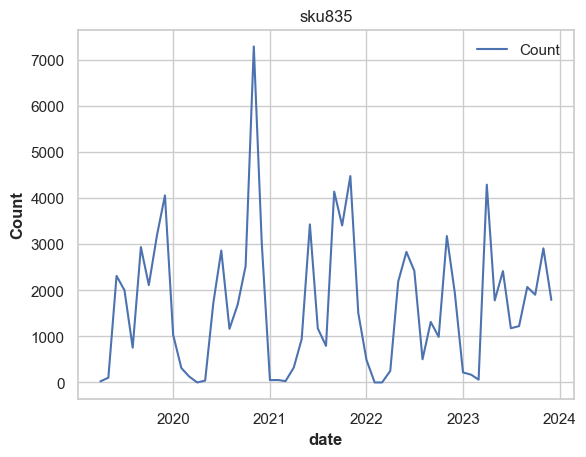

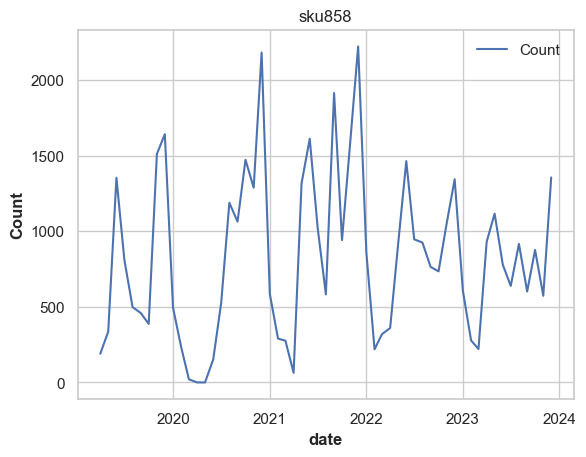

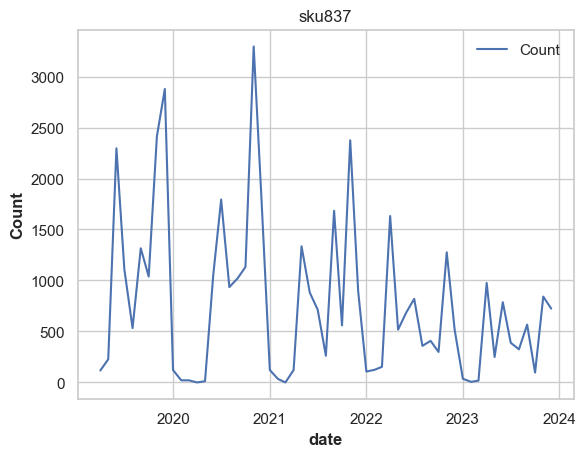

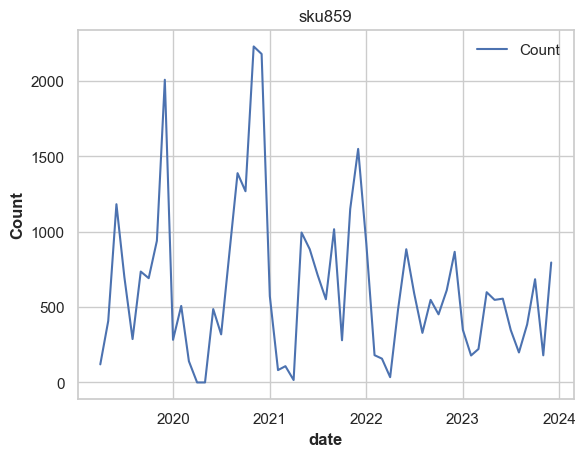

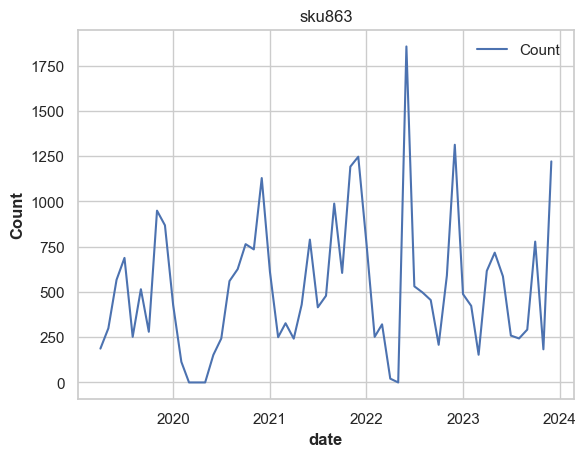

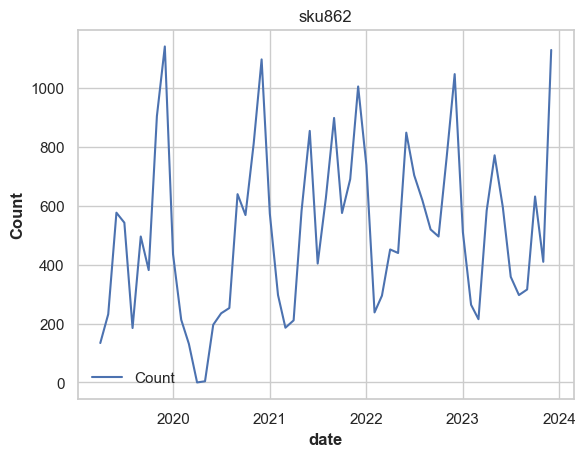

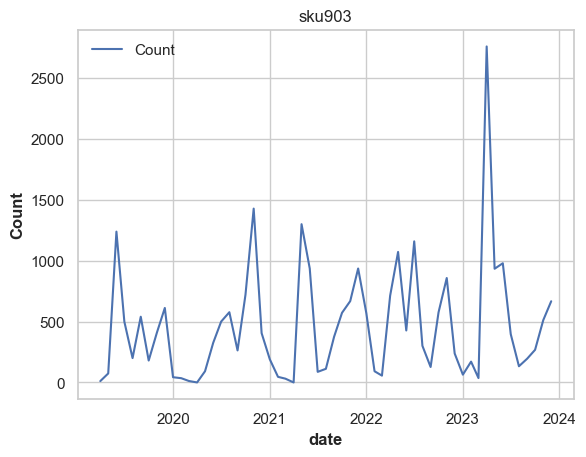

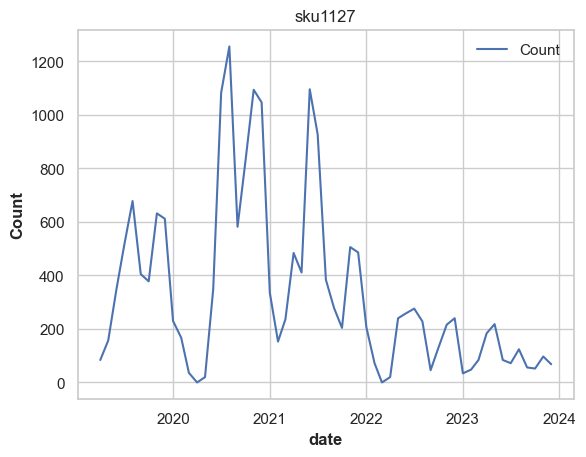

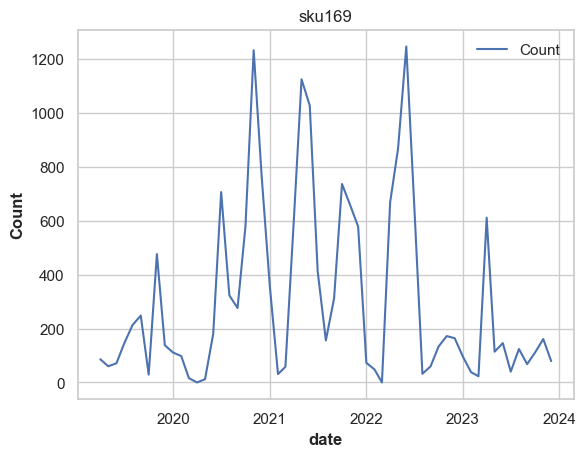

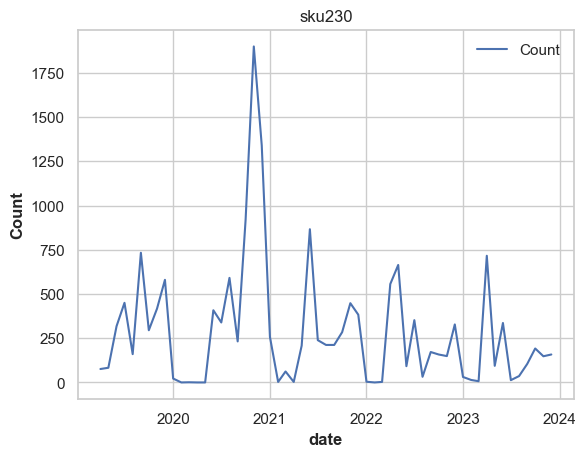

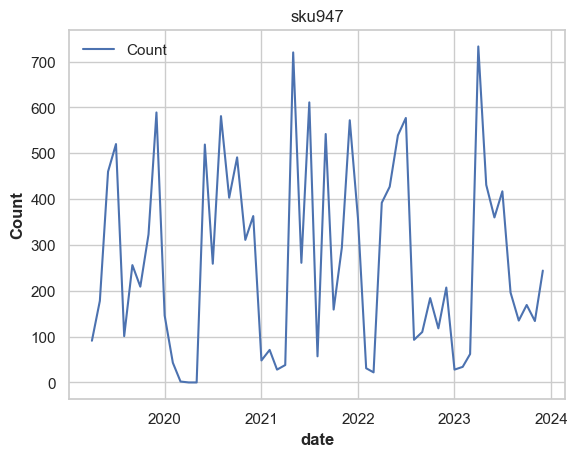

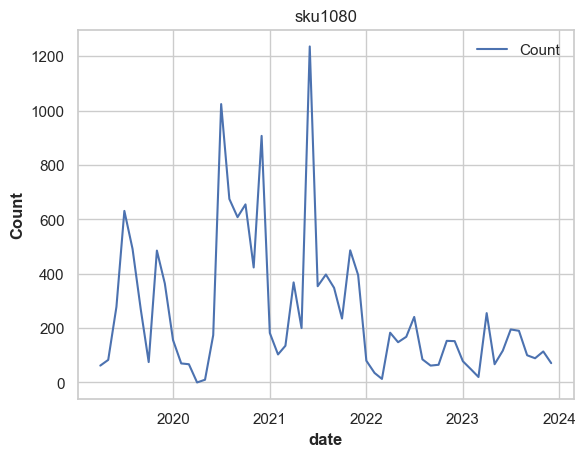

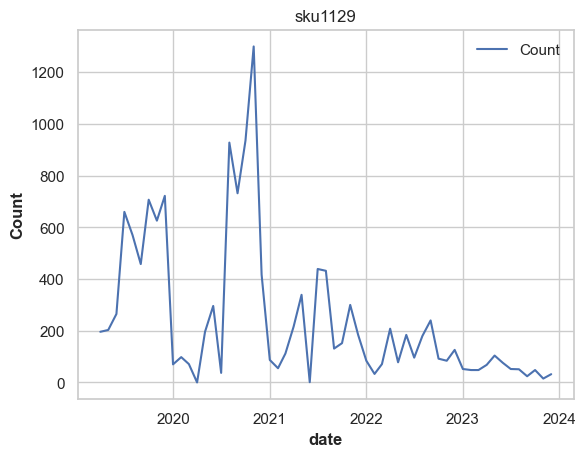

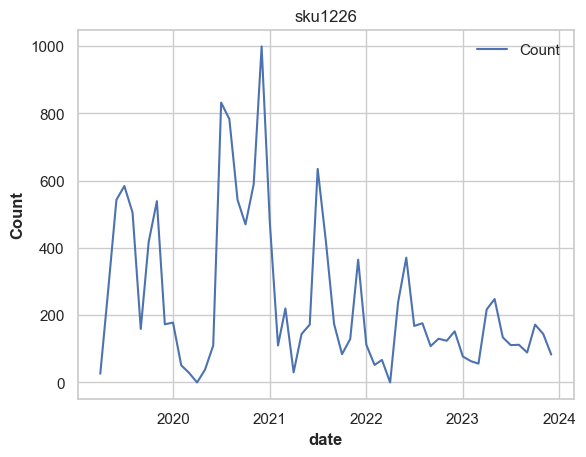

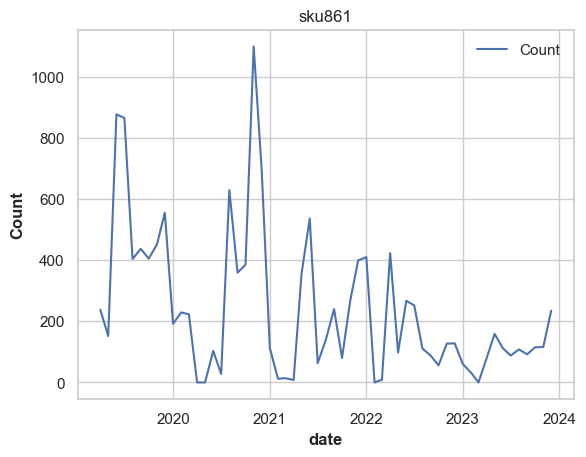

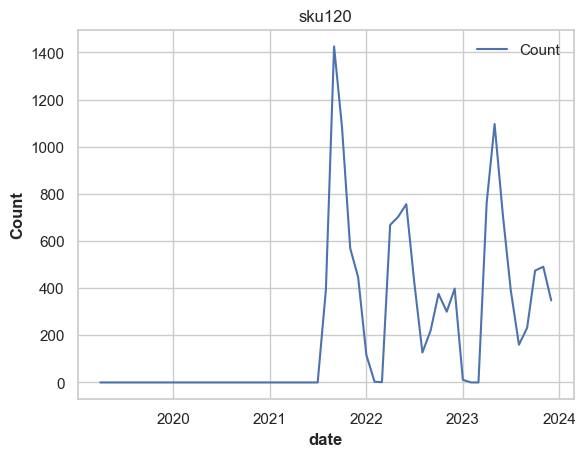

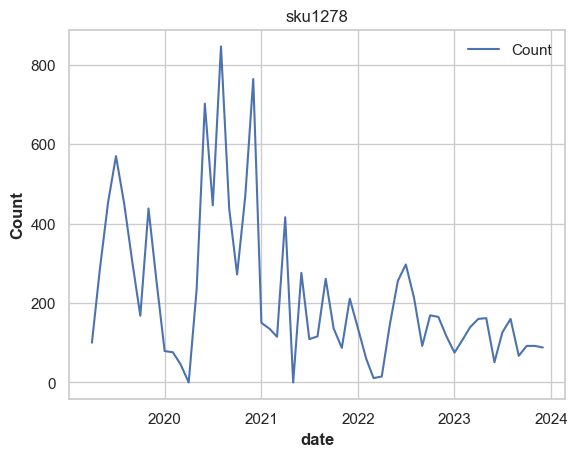

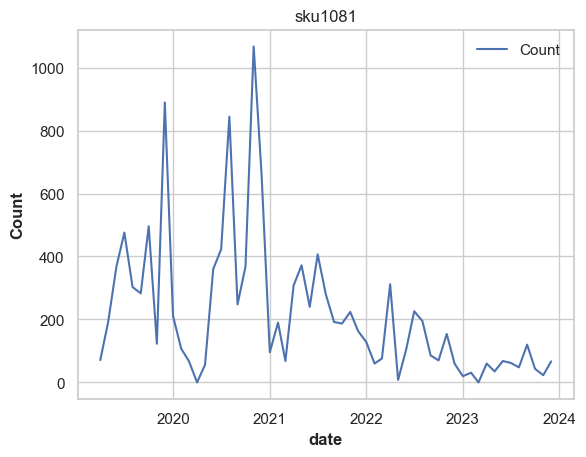

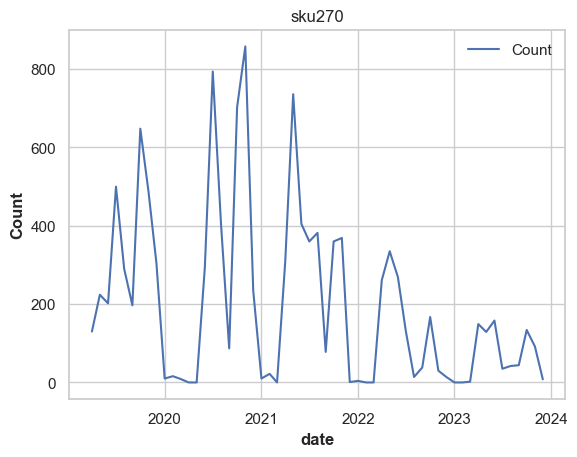

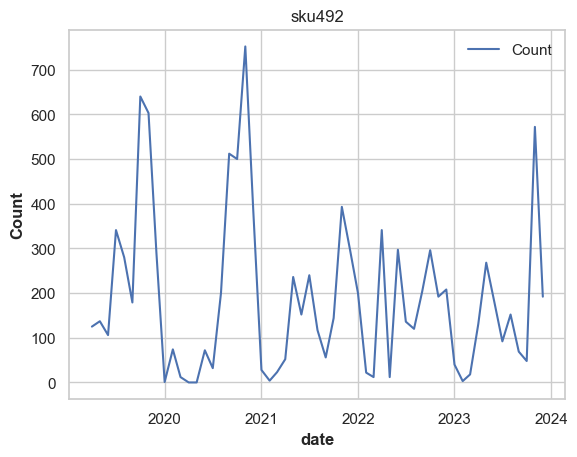

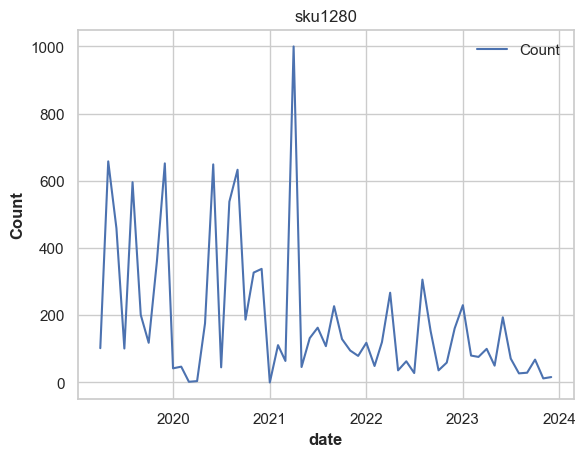

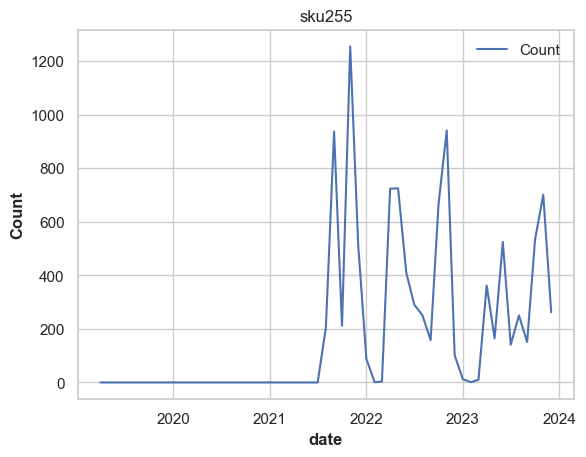

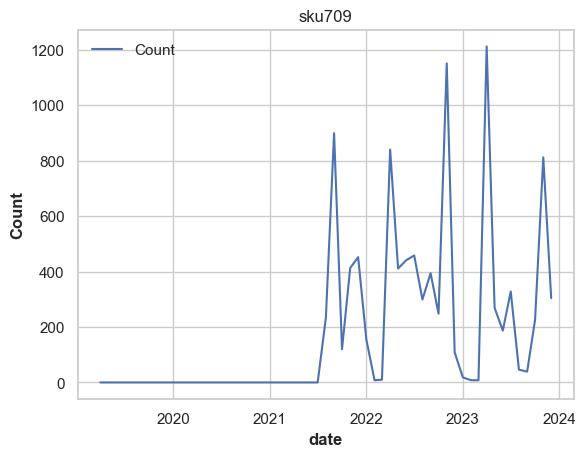

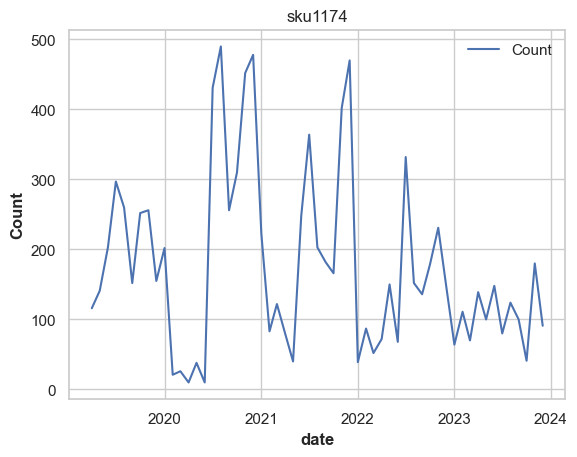

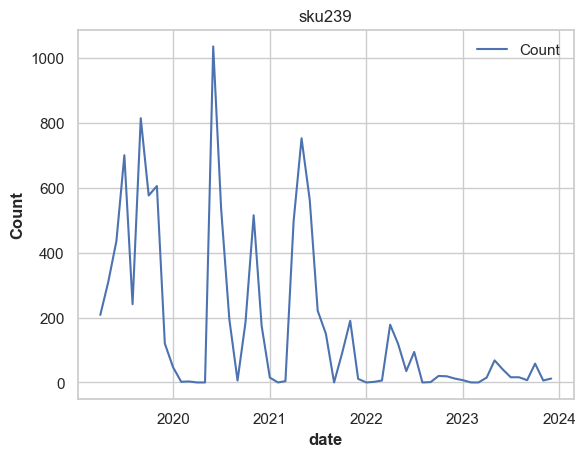

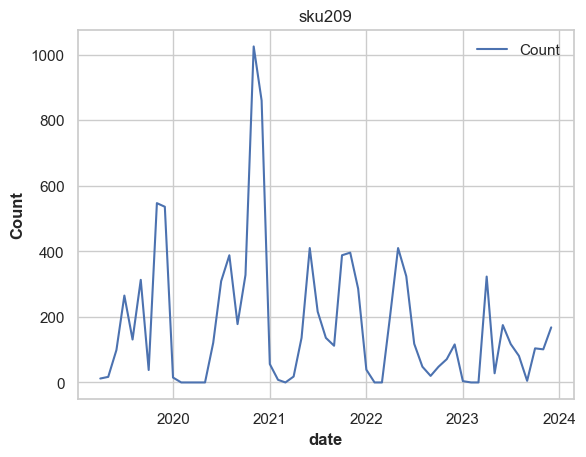

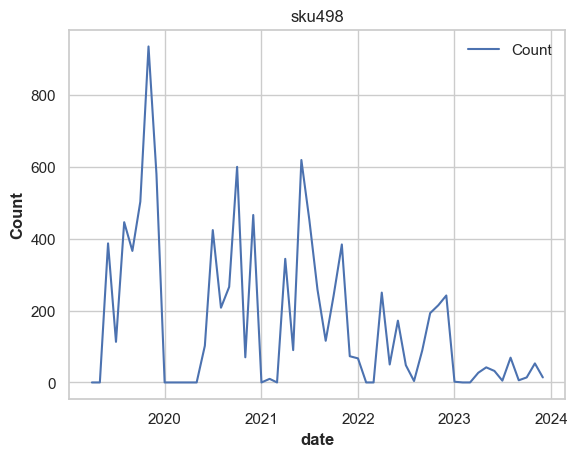

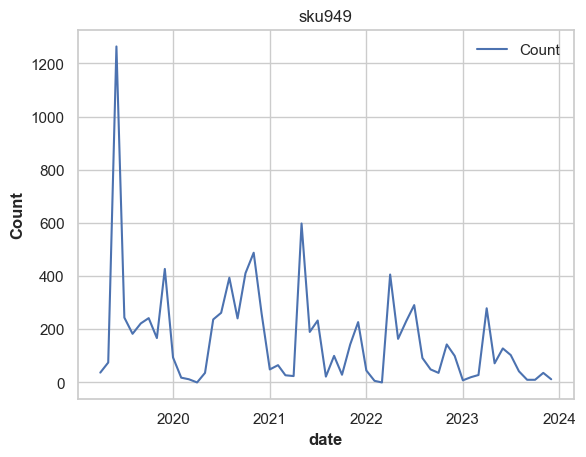

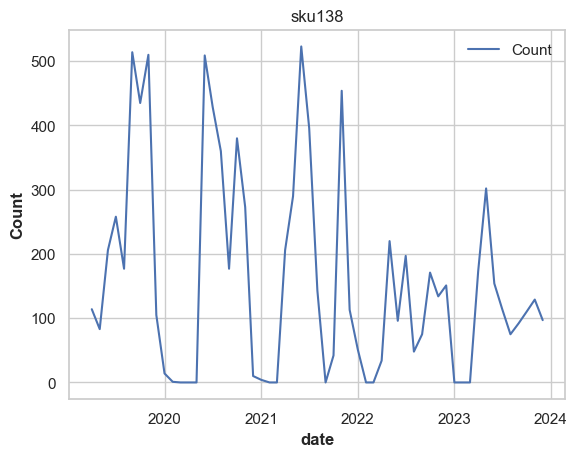

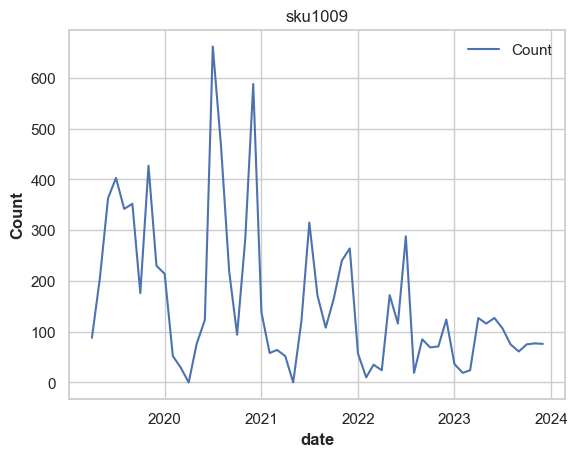

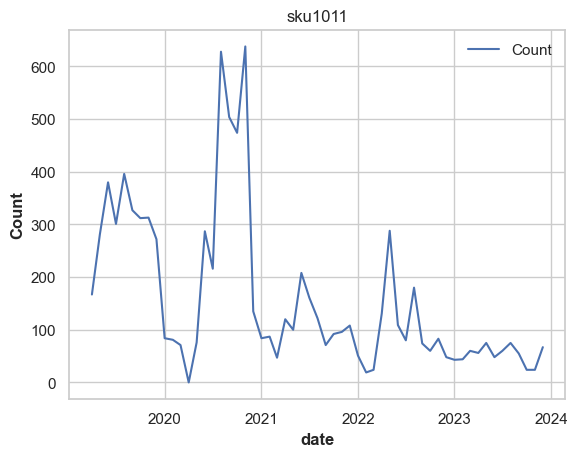

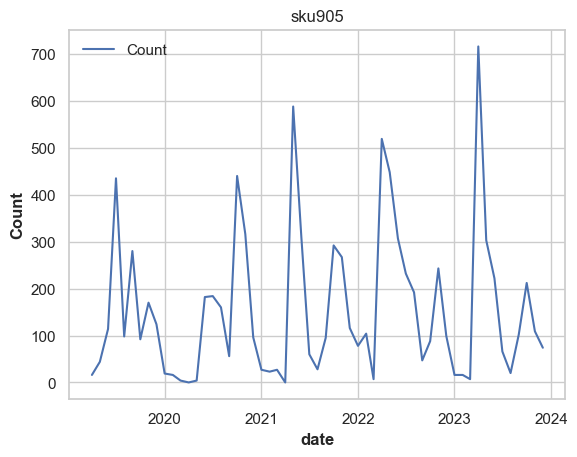

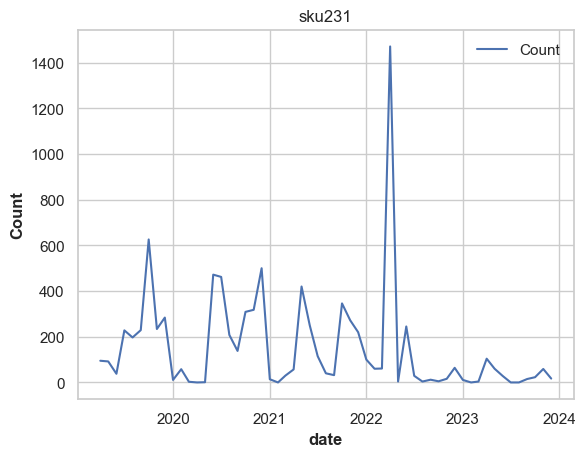

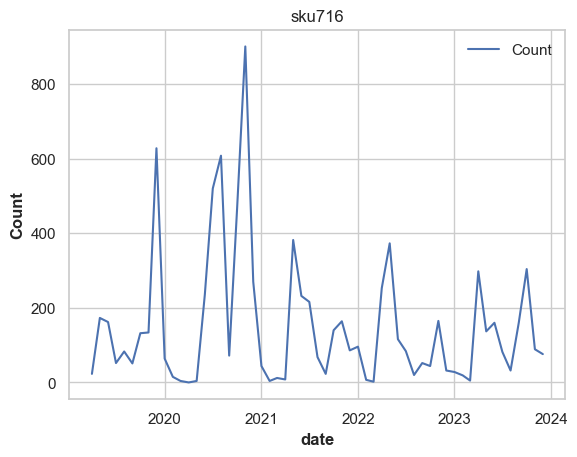

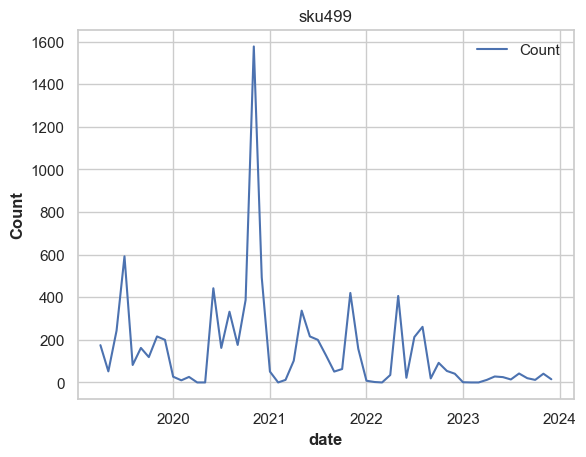

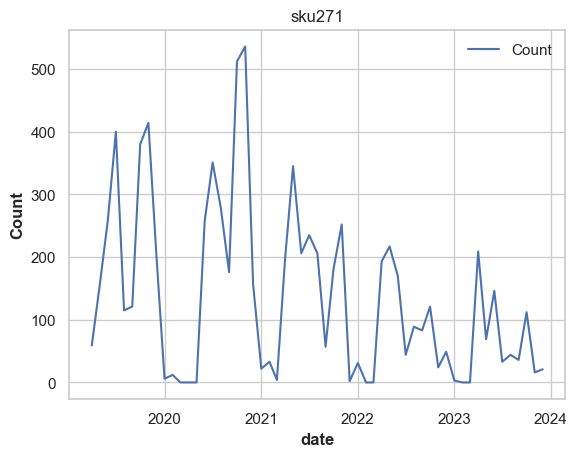

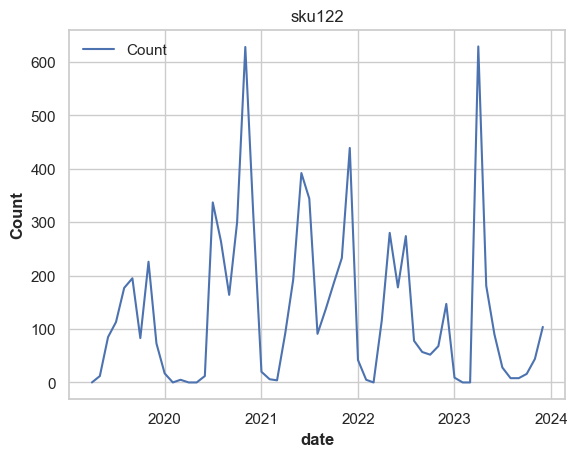

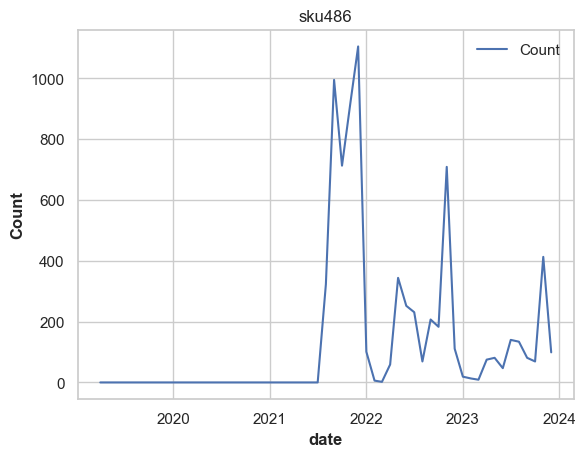

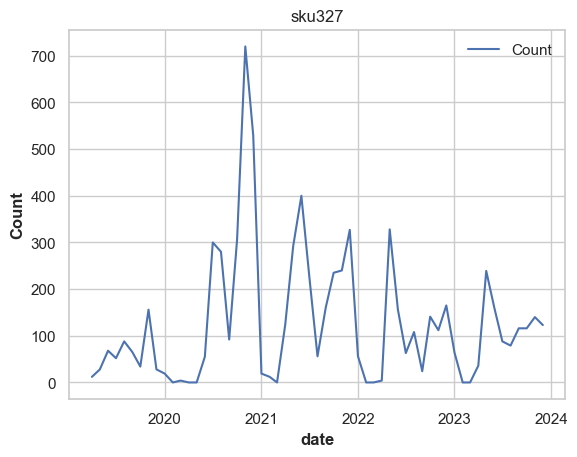

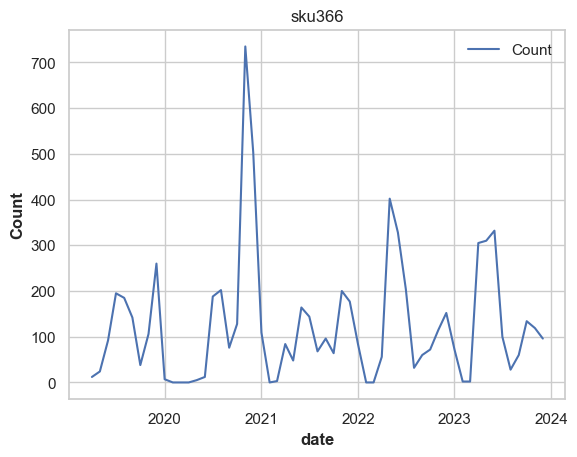

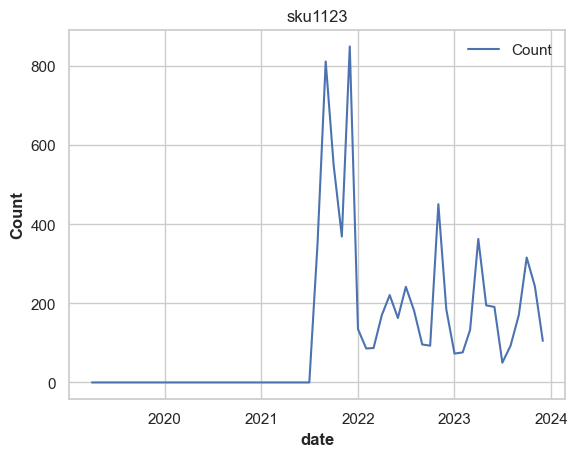

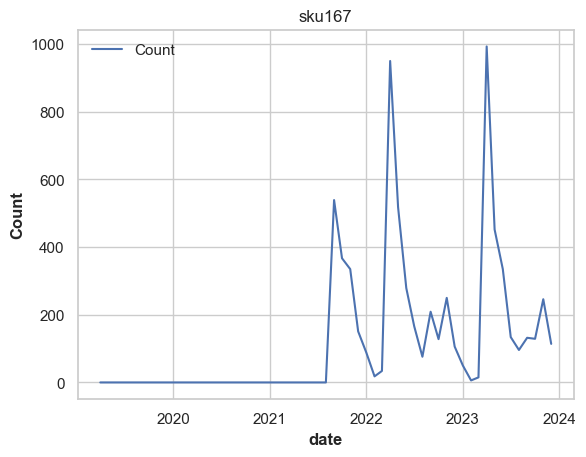

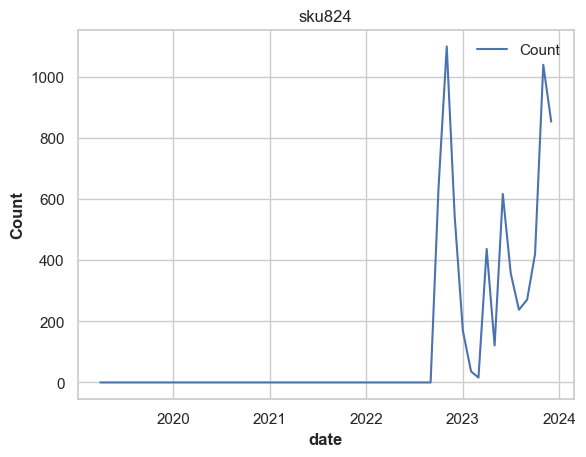

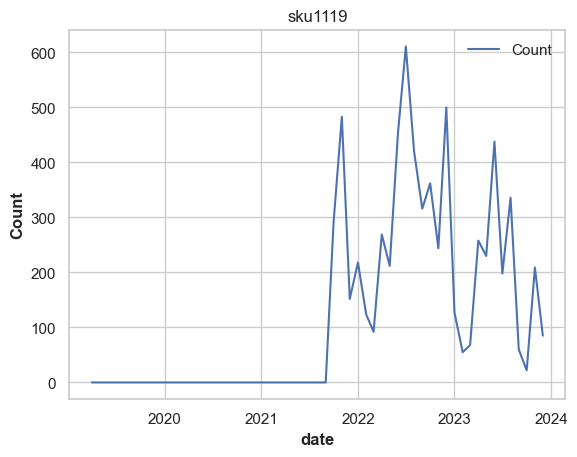

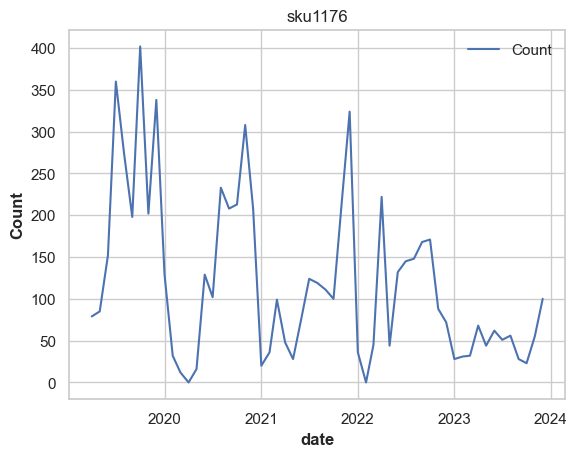

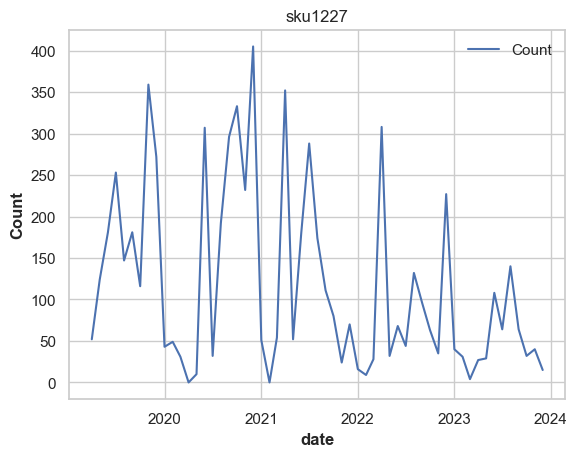

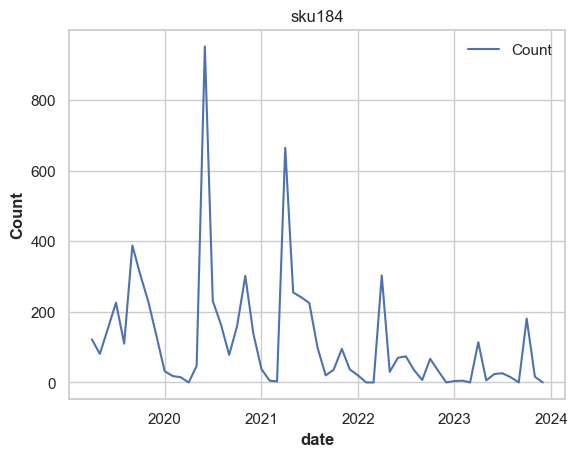

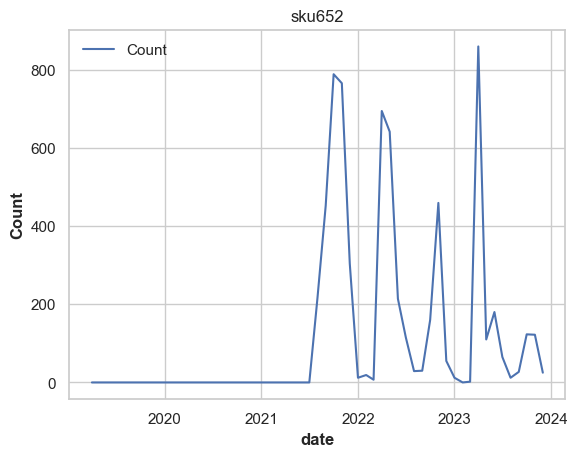

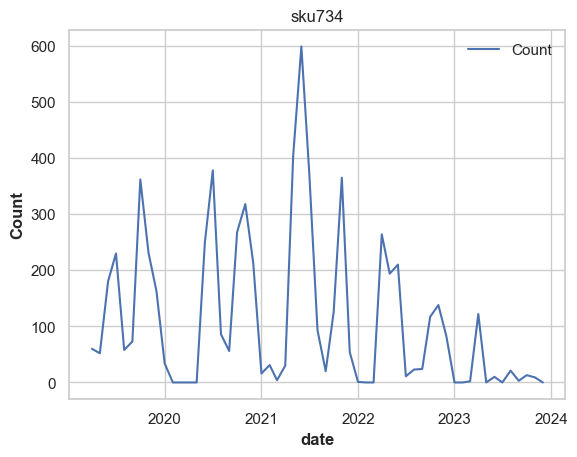

In [87]:
# Plotting the dataframes
for material_name, df in material_dataframes.items():
    sns.set(style="whitegrid")  
    sns.lineplot(data=df, x='date', y='Count', label='Count')
    plt.title(material_name)
    plt.show()  
    print()

#looks seasonal

In [88]:
from statsmodels.tsa.stattools import adfuller

adf_results = pd.DataFrame(columns=['MaterialName', 'ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Critical Values','Stationary'])

#HO: It is non stationary
#H1: It is stationary

adf_results_list = []

for material_name, df in material_dataframes.items():    
    adf_test_result = adfuller(df['Count'])    
    critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])

    is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05
    
    test_result_summary = {
        'MaterialName': material_name,
        'ADF Test Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        '#Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3],
        'Critical Values': critical_values,
        'Stationary': 'Yes' if is_stationary else 'No'
    }
    adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)

adf_results

MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -5.682113  8.439672e-07           8   
1        sku858           -4.825561  4.858230e-05           0   
2        sku837           -0.465154  8.986390e-01          11   
3        sku859           -0.783932  8.237963e-01          11   
4        sku863           -5.732720  6.543758e-07           0   
5        sku862           -0.959860  7.676215e-01          11   
6        sku903           -6.278603  3.845621e-08           0   
7       sku1127           -2.548813  1.040447e-01           2   
8        sku169           -2.583858  9.637960e-02           3   
9        sku230           -4.488251  2.064793e-04           0   
10       sku947           -5.049149  1.772404e-05           7   
11      sku1080           -3.488706  8.281943e-03           1   
12      sku1129           -1.719186  4.212556e-01           7   
13      sku1226           -3.769133  3.239396e-03           0   
14       sku861           -3.961792  1.624340e-03           3   
15       sku120           -4.294619  4.538412e-04           1   
16      sku1278           -4.255897  5.291606e-04           0   
17      sku1081           -0.801456  8.186939e-01           9   
18       sku270           -0.056846  9.535708e-01          11   
19       sku492           -4.835978  4.639194e-05           8   
20      sku1280           -6.846610  1.736330e-09           0   
21       sku255           -4.557830  1.543719e-04           0   
22       sku709           -1.031253  7.416955e-01           6   
23      sku1174           -4.359073  3.504492e-04           0   
24       sku239           -1.038145  7.390991e-01          10   
25       sku209           -0.906642  7.857771e-01          10   
26       sku498           -3.421442  1.024927e-02           1   
27       sku949           -6.227258  5.053200e-08           0   
28       sku138           -4.336077  3.844740e-04           1   
29      sku1009           -0.757460  8.312996e-01          11   
30      sku1011           -3.878781  2.196681e-03           3   
31       sku905           -5.380632  3.719358e-06           1   
32       sku231           -6.712709  3.646428e-09           0   
33       sku716           -4.940973  2.900522e-05           1   
34       sku499           -5.176252  9.828530e-06           0   
35       sku271           -0.121541  9.472502e-01          11   
36       sku122           -5.026465  1.966660e-05           0   
37       sku486           -3.497587  8.049293e-03           0   
38       sku327           -5.283377  5.926908e-06           1   
39       sku366           -5.962587  2.022540e-07           1   
40      sku1123           -3.691024  4.241199e-03           0   
41       sku167           -4.586023  1.370526e-04           0   
42       sku824            1.046874  9.947367e-01          11   
43      sku1119           -3.124924  2.476285e-02           0   
44      sku1176           -4.069868  1.085757e-03           0   
45      sku1227           -5.658090  9.518078e-07           0   
46       sku184           -5.839573  3.805318e-07           0   
47       sku652           -1.955492  3.064224e-01           4   
48       sku734           -5.569770  1.476526e-06           1   

    Number of Observations Used                      Critical Values  \
0                            48  1%: -3.575, 5%: -2.924, 10%: -2.600   
1                            56  1%: -3.553, 5%: -2.915, 10%: -2.595   
2                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
3                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
4                            56  1%: -3.553, 5%: -2.915, 10%: -2.595   
5                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
6                            56  1%: -3.553, 5%: -2.915, 10%: -2.595   
7                            54  1%: -3.558, 5%: -2.917, 10%: -2.596   
8                            53  1%: -3.560, 5%: -2.918, 10%: -2.597   
9                            56 

In [89]:
# Using 12 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 12 First Difference']=df['Count']-df['Count'].shift(12)
        adf_test_result = adfuller(df['Seasonal 12 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results

MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -5.887082  2.984057e-07           1   
1        sku858           -5.096477  1.424949e-05           0   
2        sku837           -6.791397  2.359679e-09           0   
3        sku859           -1.868161  3.471844e-01           5   
4        sku863           -6.184564  6.335237e-08           0   
5        sku862           -4.040477  1.212781e-03           0   
6        sku903           -6.760637  2.798081e-09           0   
7       sku1127           -2.927821  4.220712e-02           0   
8        sku169           -3.815355  2.754061e-03           1   
9        sku230           -4.217070  6.164062e-04           0   
10       sku947           -3.806747  2.839029e-03           1   
11      sku1080           -2.894725  4.596481e-02           1   
12      sku1129           -4.989891  2.323856e-05           0   
13      sku1226           -3.594287  5.871190e-03           0   
14       sku861           -3.512725  7.666249e-03          10   
15       sku120           -3.904024  2.005432e-03           1   
16      sku1278           -4.465137  2.272173e-04           0   
17      sku1081           -5.891106  2.923072e-07           0   
18       sku270           -2.679779  7.760318e-02           3   
19       sku492           -6.112665  9.252340e-08           0   
20      sku1280           -6.544256  9.183177e-09           0   
21       sku255           -4.593943  1.325313e-04           0   
22       sku709           -4.930888  3.035468e-05           0   
23      sku1174           -4.861794  4.136482e-05           0   
24       sku239           -4.598839  1.298075e-04           1   
25       sku209           -3.076520  2.834035e-02           4   
26       sku498           -3.663068  4.663661e-03           1   
27       sku949           -3.099986  2.655423e-02          10   
28       sku138           -5.109533  1.341327e-05           0   
29      sku1009           -6.050576  1.280516e-07           0   
30      sku1011           -3.552621  6.734152e-03           3   
31       sku905           -6.699980  3.911563e-09           0   
32       sku231           -6.851542  1.689314e-09           0   
33       sku716           -4.738349  7.124814e-05           0   
34       sku499           -4.747154  6.856512e-05           0   
35       sku271           -4.047179  1.182649e-03           0   
36       sku122           -4.798425  5.476440e-05           0   
37       sku486           -2.966875  3.810577e-02           0   
38       sku327           -3.678978  4.418756e-03           0   
39       sku366           -4.193982  6.745270e-04           0   
40      sku1123           -3.656359  4.770602e-03           0   
41       sku167           -3.536017  7.108872e-03           0   
42       sku824           -3.329899  1.359373e-02           0   
43      sku1119           -1.187682  6.788720e-01           9   
44      sku1176           -5.722559  6.887578e-07           0   
45      sku1227           -5.373481  3.849811e-06           0   
46       sku184           -5.280375  6.012160e-06           1   
47       sku652           -2.937541  4.115345e-02           0   
48       sku734           -4.018035  1.318965e-03           0   

    Number of Observations Used                      Critical Values  \
0                            43  1%: -3.593, 5%: -2.932, 10%: -2.604   
1                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
2                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
3                            39  1%: -3.610, 5%: -2.939, 10%: -2.608   
4                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
5                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
6                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
7                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
8                            43  1%: -3.593, 5%: -2.932, 10%: -2.604   
9                            44 

In [90]:
# Using 24 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 24 First Difference']=df['Count']-df['Count'].shift(24)
        adf_test_result = adfuller(df['Seasonal 24 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        # Append the test results to the list
        adf_results_list.append(test_result_summary)

# Convert the list of dictionaries to a dataframe
adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -4.134437  8.490849e-04           4   
1        sku858           -3.573862  6.280855e-03           0   
2        sku837           -4.842520  4.506517e-05           0   
3        sku859           -3.664154  4.646558e-03           0   
4        sku863           -4.701648  8.355495e-05           0   
5        sku862           -2.424621  1.349075e-01           3   
6        sku903           -3.100367  2.652605e-02           9   
7       sku1127           -2.805531  5.748802e-02           1   
8        sku169           -2.994174  3.544207e-02           1   
9        sku230           -3.433412  9.871229e-03           0   
10       sku947           -2.808815  5.702559e-02           1   
11      sku1080           -4.108125  9.390029e-04           0   
12      sku1129           -3.601638  5.729793e-03           3   
13      sku1226           -3.590787  5.939633e-03           0   
14       sku861           -2.552129  1.033004e-01           9   
15       sku120           -3.686798  4.302734e-03           1   
16      sku1278           -5.430783  2.917780e-06           0   
17      sku1081           -4.514724  1.849382e-04           0   
18       sku270           -2.880332  4.768344e-02           3   
19       sku492           -3.706402  4.024001e-03           0   
20      sku1280           -8.125586  1.125508e-12           0   
21       sku255           -4.123845  8.842657e-04           0   
22       sku709           -4.838782  4.581875e-05           0   
23      sku1174           -3.099893  2.656113e-02           0   
24       sku239           -1.417155  5.740247e-01          10   
25       sku209           -2.340663  1.591883e-01           3   
26       sku498           -4.075927  1.061170e-03           0   
27       sku949           -6.795754  2.303338e-09           0   
28       sku138           -3.036261  3.164405e-02           7   
29      sku1009           -3.992994  1.447646e-03           1   
30      sku1011           -3.694060  4.197485e-03           3   
31       sku905           -5.045352  1.803575e-05           0   
32       sku231           -4.341398  3.763338e-04           0   
33       sku716           -3.810776  2.798963e-03           0   
34       sku499           -4.384232  3.164979e-04           0   
35       sku271           -3.750140  3.460692e-03           0   
36       sku122           -3.060677  2.960347e-02           0   
37       sku486           -1.439778  5.630645e-01           0   
38       sku327           -3.084130  2.775014e-02           1   
39       sku366           -3.901327  2.025100e-03           4   
40      sku1123           -1.875200  3.438160e-01           0   
41       sku167           -3.600345  5.754437e-03           0   
42       sku824           -2.030167  2.735045e-01           0   
43      sku1119           -0.557981  8.801967e-01          10   
44      sku1176           -2.841749  5.255317e-02           7   
45      sku1227           -5.128638  1.227449e-05           0   
46       sku184           -4.890451  3.639812e-05           0   
47       sku652           -2.501158  1.151929e-01           0   
48       sku734           -0.198061  9.387523e-01          10   

    Number of Observations Used                      Critical Values  \
0                            28  1%: -3.689, 5%: -2.972, 10%: -2.625   
1                            32  1%: -3.654, 5%: -2.957, 10%: -2.618   
2                            32  1%: -3.654, 5%: -2.957, 10%: -2.618   
3                            32  1%: -3.654, 5%: -2.957, 10%: -2.618   
4                            32  1%: -3.654, 5%: -2.957, 10%: -2.618   
5                            29  1%: -3.679, 5%: -2.968, 10%: -2.623   
6                            23  1%: -3.753, 5%: -2.998, 10%: -2.639   
7                            31  1%: -3.661, 5%: -2.961, 10%: -2.619   
8                            31  1%: -3.661, 5%: -2.961, 10%: -2.619   
9                            32 

In [91]:
# Using 6 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 6 First Difference']=df['Count']-df['Count'].shift(6)
        adf_test_result = adfuller(df['Seasonal 6 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -5.447510  2.689892e-06           7   
1        sku858           -7.207521  2.279651e-10           5   
2        sku837          -11.129095  3.316671e-20           5   
3        sku859           -1.684208  4.392669e-01          11   
4        sku863           -5.729315  6.657047e-07           5   
5        sku862           -8.102158  1.291161e-12           5   
6        sku903           -4.722290  7.640288e-05          11   
7       sku1127           -2.357637  1.540517e-01           6   
8        sku169           -1.686358  4.381548e-01           8   
9        sku230           -3.056739  2.992478e-02           6   
10       sku947           -7.748108  1.019077e-11           5   
11      sku1080           -2.194611  2.082071e-01           7   
12      sku1129           -2.455709  1.266259e-01          11   
13      sku1226           -3.260326  1.674775e-02          11   
14       sku861           -4.572232  1.452788e-04          11   
15       sku120           -2.380209  1.474005e-01           7   
16      sku1278           -5.380475  3.722166e-06           5   
17      sku1081           -6.549738  8.912901e-09           5   
18       sku270           -1.894275  3.347591e-01           8   
19       sku492           -4.145013  8.152696e-04           9   
20      sku1280           -5.486746  2.221185e-06           5   
21       sku255           -2.484812  1.192137e-01           6   
22       sku709           -2.409368  1.391097e-01           6   
23      sku1174           -8.881175  1.316705e-14           5   
24       sku239           -2.286431  1.763817e-01          11   
25       sku209           -6.341301  2.750509e-08           4   
26       sku498           -2.480260  1.203514e-01          11   
27       sku949           -3.690792  4.244547e-03          10   
28       sku138          -10.798755  2.043292e-19           5   
29      sku1009           -9.049363  4.887218e-15           5   
30      sku1011           -3.544240  6.921003e-03          11   
31       sku905           -7.855374  5.460743e-12           5   
32       sku231           -4.629993  1.136889e-04           5   
33       sku716           -3.220013  1.885508e-02          11   
34       sku499           -5.115427  1.305149e-05           5   
35       sku271           -2.795416  5.893154e-02           7   
36       sku122           -3.512566  7.670167e-03           6   
37       sku486           -2.163002  2.199467e-01           6   
38       sku327           -2.635771  8.582715e-02           6   
39       sku366           -3.494509  8.129227e-03          11   
40      sku1123           -2.348132  1.569137e-01           6   
41       sku167           -2.126390  2.340363e-01           6   
42       sku824           -1.307556  6.257086e-01          11   
43      sku1119           -0.800263  8.190448e-01           7   
44      sku1176           -8.874114  1.372672e-14           5   
45      sku1227           -5.907085  2.692724e-07           5   
46       sku184           -1.566976  5.001580e-01          11   
47       sku652           -1.794031  3.834292e-01           6   
48       sku734           -3.237796  1.789852e-02           6   

    Number of Observations Used                      Critical Values  \
0                            43  1%: -3.593, 5%: -2.932, 10%: -2.604   
1                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
2                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
3                            39  1%: -3.610, 5%: -2.939, 10%: -2.608   
4                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
5                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
6                            39  1%: -3.610, 5%: -2.939, 10%: -2.608   
7                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
8                            42  1%: -3.597, 5%: -2.933, 10%: -2.605   
9                            44 

In [92]:
# Using 4 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 4 First Difference']=df['Count']-df['Count'].shift(4)
        adf_test_result = adfuller(df['Seasonal 4 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -9.328915  9.444300e-16           7   
1        sku858           -7.063133  5.161670e-10           7   
2        sku837          -10.396899  1.954563e-18           7   
3        sku859           -2.977505  3.704919e-02           8   
4        sku863           -6.519189  1.052577e-08           7   
5        sku862           -3.236808  1.795051e-02           8   
6        sku903           -3.987665  1.476499e-03          11   
7       sku1127           -4.867744  4.028276e-05           6   
8        sku169           -2.137418  2.297372e-01           8   
9        sku230           -4.689135  8.819799e-05           7   
10       sku947           -7.774299  8.752421e-12           7   
11      sku1080           -2.007695  2.832091e-01           9   
12      sku1129           -4.991956  2.302121e-05           7   
13      sku1226           -2.275259  1.800715e-01          11   
14       sku861           -5.963462  2.013410e-07          11   
15       sku120           -2.049477  2.653092e-01           8   
16      sku1278           -5.050582  1.760771e-05           7   
17      sku1081           -4.517291  1.829673e-04           6   
18       sku270           -3.273731  1.609431e-02           8   
19       sku492           -4.566577  1.487866e-04          11   
20      sku1280           -3.233461  1.812768e-02          11   
21       sku255           -2.423749  1.351452e-01           8   
22       sku709           -1.102416  7.141073e-01          10   
23      sku1174           -2.604701  9.202959e-02          11   
24       sku239           -1.830545  3.654058e-01          10   
25       sku209           -5.789847  4.901263e-07           7   
26       sku498           -2.766796  6.317553e-02          11   
27       sku949           -3.361194  1.235507e-02          11   
28       sku138           -7.306617  1.296501e-10           7   
29      sku1009           -6.054255  1.256161e-07           7   
30      sku1011           -4.684650  8.992120e-05           7   
31       sku905           -7.023328  6.458740e-10           7   
32       sku231           -4.698093  8.484967e-05           7   
33       sku716           -2.068524  2.573580e-01          11   
34       sku499           -4.716575  7.832199e-05           7   
35       sku271           -2.456708  1.263661e-01           9   
36       sku122           -5.715333  7.142750e-07           7   
37       sku486           -2.374275  1.491290e-01          11   
38       sku327           -2.630005  8.695299e-02           8   
39       sku366           -5.029939  1.935635e-05           7   
40      sku1123           -5.235637  7.432682e-06           3   
41       sku167           -2.390668  1.443878e-01           8   
42       sku824           -2.460937  1.252702e-01           8   
43      sku1119           -2.032509  2.725032e-01           7   
44      sku1176           -5.899550  2.799043e-07           7   
45      sku1227           -4.803720  5.350180e-05           7   
46       sku184           -6.476375  1.328022e-08           7   
47       sku652           -2.121791  2.358432e-01           9   
48       sku734           -2.755013  6.499267e-02           8   

    Number of Observations Used                      Critical Values  \
0                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
1                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
2                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
3                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
4                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
5                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
6                            41  1%: -3.601, 5%: -2.935, 10%: -2.606   
7                            46  1%: -3.581, 5%: -2.927, 10%: -2.602   
8                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
9                            45 

In [93]:
# Using 1 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 1 First Difference']=df['Count']-df['Count'].shift(1)
        adf_test_result = adfuller(df['Seasonal 1 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -6.695650  4.006002e-09          10   
1        sku858           -5.058578  1.697226e-05          10   
2        sku837           -8.210930  6.821893e-13          10   
3        sku859           -5.214244  8.222082e-06          10   
4        sku863           -4.370091  3.351770e-04          11   
5        sku862           -3.104943  2.618957e-02          11   
6        sku903           -5.480460  2.290526e-06           9   
7       sku1127           -4.756233  6.589984e-05           8   
8        sku169           -8.242994  5.651050e-13           2   
9        sku230           -6.020873  1.494844e-07           2   
10       sku947           -5.143813  1.143721e-05          10   
11      sku1080          -11.028856  5.735682e-20           0   
12      sku1129           -5.300248  5.469172e-06           6   
13      sku1226           -4.794329  5.576081e-05           9   
14       sku861           -5.749834  6.002187e-07           3   
15       sku120           -5.945655  2.207460e-07           3   
16      sku1278           -6.586842  7.278720e-09           2   
17      sku1081           -4.857491  4.216475e-05           9   
18       sku270           -5.233322  7.514424e-06          10   
19       sku492           -4.850353  4.352452e-05          11   
20      sku1280           -4.399292  2.976905e-04           8   
21       sku255           -7.319427  1.205050e-10           3   
22       sku709           -7.560607  3.017177e-11           5   
23      sku1174           -5.854925  3.518290e-07           9   
24       sku239           -6.218681  5.288396e-08           9   
25       sku209           -5.861142  3.408199e-07           9   
26       sku498           -5.271000  6.286117e-06           9   
27       sku949           -4.396990  3.004946e-04           9   
28       sku138           -5.860597  3.417710e-07          10   
29      sku1009           -5.084967  1.502827e-05          11   
30      sku1011           -4.827783  4.810704e-05           5   
31       sku905           -5.412127  3.194114e-06          10   
32       sku231           -5.722183  6.900627e-07           4   
33       sku716           -4.793232  5.603066e-05           9   
34       sku499           -6.483840  1.275347e-08           3   
35       sku271           -6.222212  5.190283e-08           9   
36       sku122           -4.692161  8.705285e-05           9   
37       sku486           -8.658591  4.891889e-14           0   
38       sku327           -6.502571  1.152067e-08           3   
39       sku366           -4.995680  2.263421e-05           9   
40      sku1123           -7.412027  7.092855e-11           1   
41       sku167           -2.104168  2.428421e-01          11   
42       sku824           -1.376514  5.934824e-01          11   
43      sku1119           -4.641607  1.081842e-04           6   
44      sku1176           -4.764686  6.350802e-05          11   
45      sku1227           -5.010851  2.112149e-05           7   
46       sku184           -4.822993  4.913729e-05          10   
47       sku652           -7.889202  4.483655e-12           3   
48       sku734           -5.552391  1.608860e-06           9   

    Number of Observations Used                      Critical Values  \
0                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
1                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
2                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
3                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
4                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
5                            44  1%: -3.589, 5%: -2.930, 10%: -2.603   
6                            46  1%: -3.581, 5%: -2.927, 10%: -2.602   
7                            47  1%: -3.578, 5%: -2.925, 10%: -2.601   
8                            53  1%: -3.560, 5%: -2.918, 10%: -2.597   
9                            53 

In [94]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL


adf_results_list = []

for material_name, df in material_dataframes.items():
    # STL decomposition
    stl = STL(df['Count'], seasonal=11)  
    res = stl.fit()

    # Extract trend component and residual
    df['Trend'] = res.trend
    df['Residual'] = res.resid

    # Perform ADF test on the residual
    adf_test_result = adfuller(df['Residual'].dropna())
    critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])
    is_stationary = adf_test_result[1] < 0.05  # Reject null if p-value < 0.05

    test_result_summary = {
        'MaterialName': material_name,
        'ADF Test Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        '#Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3],
        'Critical Values': critical_values,
        'Stationary': 'Yes' if is_stationary else 'No'
    }

    adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)

adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0        sku835           -2.722387  7.024385e-02          11   
1        sku858           -5.480501  2.290064e-06           4   
2        sku837           -2.317042  1.665304e-01          11   
3        sku859           -5.947549  2.185978e-07           4   
4        sku863           -2.489989  1.179290e-01          11   
5        sku862           -1.633686  4.655618e-01           9   
6        sku903           -3.551344  6.762325e-03          11   
7       sku1127           -2.268900  1.821946e-01          11   
8        sku169           -5.383488  3.668448e-06           4   
9        sku230           -3.563763  6.492804e-03          11   
10       sku947           -5.373180  3.855398e-06           5   
11      sku1080           -1.787753  3.865589e-01          11   
12      sku1129           -3.558196  6.612404e-03          11   
13      sku1226           -6.149205  7.634759e-08           1   
14       sku861           -3.533700  7.162620e-03          11   
15       sku120           -5.695289  7.899861e-07           3   
16      sku1278           -5.246667  7.054892e-06          11   
17      sku1081           -2.556667  1.022880e-01          11   
18       sku270           -1.716715  4.225218e-01           9   
19       sku492           -4.924480  3.124332e-05          11   
20      sku1280           -2.521737  1.102746e-01          11   
21       sku255           -5.499096  2.090857e-06           3   
22       sku709           -6.669862  4.617008e-09           1   
23      sku1174           -6.867914  1.542067e-09           0   
24       sku239           -3.101494  2.644281e-02          11   
25       sku209           -2.988523  3.598018e-02          11   
26       sku498           -4.208043  6.385455e-04          11   
27       sku949           -6.155676  7.378802e-08           4   
28       sku138           -5.683833  8.367239e-07           6   
29      sku1009           -4.519744  1.811027e-04          11   
30      sku1011           -4.801306  5.407385e-05          11   
31       sku905           -5.264506  6.482942e-06           5   
32       sku231           -2.888935  4.664997e-02          11   
33       sku716           -2.998525  3.503239e-02          11   
34       sku499           -3.705222  4.040296e-03          11   
35       sku271           -2.996443  3.522793e-02          11   
36       sku122           -5.327299  4.805944e-06           4   
37       sku486           -5.349096  4.328981e-06           3   
38       sku327           -7.209665  2.252052e-10           1   
39       sku366           -4.535799  1.693370e-04          11   
40      sku1123           -4.155308  7.835684e-04          11   
41       sku167           -2.980128  3.679234e-02           7   
42       sku824           -5.122649  1.262100e-05           5   
43      sku1119           -2.141681  2.280878e-01           7   
44      sku1176           -4.231602  5.822764e-04          11   
45      sku1227           -2.806580  5.734002e-02          11   
46       sku184           -2.682630  7.709250e-02          11   
47       sku652           -5.915459  2.579204e-07           3   
48       sku734           -2.336097  1.605901e-01          11   

    Number of Observations Used                      Critical Values  \
0                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
1                            52  1%: -3.563, 5%: -2.919, 10%: -2.597   
2                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
3                            52  1%: -3.563, 5%: -2.919, 10%: -2.597   
4                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
5                            47  1%: -3.578, 5%: -2.925, 10%: -2.601   
6                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
7                            45  1%: -3.585, 5%: -2.928, 10%: -2.602   
8                            52  1%: -3.563, 5%: -2.919, 10%: -2.597   
9                            45 

In [116]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import Croston, XGBModel
from sklearn.metrics import mean_squared_error

time_series_dict = {}
for material_name, df in material_dataframes.items():
    series = TimeSeries.from_dataframe(df, value_cols='Count', fill_missing_dates=True, freq='MS')
    time_series_dict[material_name] = series

train_series = {}
val_series = {}
for material_name, series in time_series_dict.items():
    train_series[material_name] = series

validation_results = []
for material_name, series in train_series.items():
    model = Croston(version="optimized")
    model.fit(series)
    pred = model.predict(2).values().flatten()[1]    
    validation_results.append((material_name, pred))

Croston_models_df = pd.DataFrame(validation_results, columns=['MaterialNumber', 'Predicted_Croston'])
Croston_models_df

MaterialNumber  Predicted_Croston
0          sku835        1841.256714
1          sku858         848.022522
2          sku837         523.766724
3          sku859         506.119385
4          sku863         558.946472
5          sku862         657.784302
6          sku903         547.779114
7         sku1127          81.559723
8          sku169         120.930229
9          sku230         153.673828
10         sku947         245.372742
11        sku1080         107.251305
12        sku1129          38.030449
13        sku1226         119.834938
14         sku861         125.905586
15         sku120         417.828125
16        sku1278          97.192146
17        sku1081          56.284107
18         sku270          69.239746
19         sku492         178.438232
20        sku1280          74.307381
21         sku255         331.077484
22         sku709         330.756348
23        sku1174         109.060852
24         sku239          23.168198
25         sku209          99.454163
26         sku498          41.328556
27         sku949          68.396507
28         sku138         106.842079
29        sku1009          79.708893
30        sku1011          49.689156
31         sku905         155.904846
32         sku231          66.934402
33         sku716         123.210815
34         sku499          49.737579
35         sku271          49.213921
36         sku122          86.493629
37         sku486         160.539047
38         sku327         107.688606
39         sku366         123.648552
40        sku1123         179.667862
41         sku167         194.763107
42         sku824         500.548553
43        sku1119         182.969879
44        sku1176          60.537754
45        sku1227          52.229942
46         sku184          54.001930
47         sku652         155.310364
48         sku734          35.144093

In [114]:
# Fit XGBoost model for each material with different lags and determine best accuracy
validation_results_XGB = []

for material_name, series in train_series.items():
    model = XGBModel(lags=12)
    model.fit(series)
    pred = model.predict(2).values().flatten()[1]
            
    validation_results_XGB.append((material_name, pred))

XGB_models_df = pd.DataFrame(validation_results_XGB, columns=['MaterialNumber', 'Predicted_XGB'])
XGB_models_df

MaterialNumber  Predicted_XGB
0          sku835      53.495850
1          sku858     708.903809
2          sku837     127.313835
3          sku859     365.272705
4          sku863     336.895172
5          sku862     665.988525
6          sku903     246.589478
7         sku1127      59.445339
8          sku169      72.094780
9          sku230     292.330841
10         sku947      12.831897
11        sku1080      52.508968
12        sku1129      50.728710
13        sku1226     105.879959
14         sku861      22.756176
15         sku120     666.280579
16        sku1278     111.906898
17        sku1081      53.468327
18         sku270      15.160123
19         sku492     156.623276
20        sku1280     163.236176
21         sku255      22.215746
22         sku709     279.124207
23        sku1174     107.859459
24         sku239      12.995519
25         sku209       8.279514
26         sku498      21.243378
27         sku949      46.454670
28         sku138      15.239608
29        sku1009      24.976204
30        sku1011      74.612625
31         sku905       1.045289
32         sku231      24.022310
33         sku716       6.502989
34         sku499       9.480575
35         sku271      18.453054
36         sku122     185.567307
37         sku486      10.532748
38         sku327      15.145450
39         sku366       2.000449
40        sku1123     147.159393
41         sku167     113.755386
42         sku824     158.157089
43        sku1119     180.071594
44        sku1176     128.652542
45        sku1227      23.017212
46         sku184       3.258283
47         sku652     123.004105
48         sku734       9.255033

In [120]:
def prepare_data(df, material):
    df_material = df[df['material'] == material].drop('material', axis=1).T
    df_material.columns = ['Sales']
    df_material.index = pd.to_datetime(df_material.index, format='%m/%d/%Y')
    return df_material

In [123]:
# ARIMA model
def forecast_sales_arima(df, material, order=(0,1,0)):
    df_material = prepare_data(df, material)
    train = df_material
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=2)
    predicted = forecast.values
    
    return predicted[1]

results = []

for material in materials:
    predicted = forecast_sales_arima(data, material)
    results.append((material, predicted))

results_df = pd.DataFrame(results, columns=['MaterialNumber', 'Predicted_ARIMA'])
results_df

MaterialNumber  Predicted_ARIMA
0          sku835           1792.0
1          sku858           1355.0
2          sku837            724.0
3          sku859            796.0
4          sku863           1221.0
5          sku862           1130.0
6          sku903            667.0
7         sku1127             68.0
8          sku169             79.0
9          sku230            158.0
10         sku947            244.0
11        sku1080             71.0
12        sku1129             32.0
13        sku1226             83.0
14         sku861            235.0
15         sku120            348.0
16        sku1278             88.0
17        sku1081             67.0
18         sku270              8.0
19         sku492            192.0
20        sku1280             16.0
21         sku255            262.0
22         sku709            304.0
23        sku1174             91.0
24         sku239             12.0
25         sku209            168.0
26         sku498             14.0
27         sku949             12.0
28         sku138             97.0
29        sku1009             76.0
30        sku1011             67.0
31         sku905             74.0
32         sku231             17.0
33         sku716             76.0
34         sku499             15.0
35         sku271             21.0
36         sku122            104.0
37         sku486             99.0
38         sku327            123.0
39         sku366             96.0
40        sku1123            105.0
41         sku167            114.0
42         sku824            854.0
43        sku1119             85.0
44        sku1176            100.0
45        sku1227             15.0
46         sku184              0.0
47         sku652             25.0
48         sku734              0.0

In [129]:
# Exponential Smoothing model
def forecast_sales_ets(df, material, seasonal_periods=12, trend='add', seasonal='add'):
    df_material = prepare_data(df, material)
    train = df_material    
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=2)
    predicted = forecast.values
    return predicted[1]
    
results_ets = []

for material in materials:
    predicted = forecast_sales_ets(data, material)
    results_ets.append((material, predicted))

results_ets_df = pd.DataFrame(results_ets, columns=['MaterialNumber', 'Predicted_ETS'])
results_ets_df


MaterialNumber  Predicted_ETS
0          sku835    -300.271471
1          sku858    -280.403915
2          sku837    -653.040667
3          sku859    -750.068162
4          sku863     236.499522
5          sku862     147.454205
6          sku903     254.009581
7         sku1127    -500.717453
8          sku169    -406.913849
9          sku230    -548.237434
10         sku947     -25.905404
11        sku1080    -268.726541
12        sku1129    -407.778208
13        sku1226    -241.475873
14         sku861    -157.389900
15         sku120     171.755724
16        sku1278    -126.133617
17        sku1081    -204.921740
18         sku270    -223.027094
19         sku492     -46.223605
20        sku1280    -111.991405
21         sku255     157.381529
22         sku709      28.135579
23        sku1174     -81.357774
24         sku239    -270.332427
25         sku209    -302.808974
26         sku498    -300.462896
27         sku949    -112.263785
28         sku138     -98.397045
29        sku1009    -100.626313
30        sku1011     -86.146608
31         sku905      75.830852
32         sku231    -159.490795
33         sku716     -89.599273
34         sku499    -288.457482
35         sku271    -132.785751
36         sku122    -124.669907
37         sku486    -157.476247
38         sku327    -120.549196
39         sku366    -181.056873
40        sku1123     -19.673670
41         sku167      96.815622
42         sku824     861.248564
43        sku1119       4.204240
44        sku1176    -125.011384
45        sku1227    -107.432039
46         sku184    -124.715081
47         sku652    -115.111112
48         sku734    -157.541122

In [135]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#Function to forecast sales using LSTM
def forecast_sales_lstm(df, material):
    df_material = prepare_data(df, material).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_material_scaled = scaler.fit_transform(df_material)    
    train = df_material_scaled
    
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    # Make predictions for the next two months (Jan and Feb 2024)
    predictions = []
    current_input = train[-look_back:]
    
    for _ in range(2):  # Forecast for the next 2 months
        current_input = np.reshape(current_input, (1, look_back, 1))
        predicted = model.predict(current_input)
        predicted_unscaled = scaler.inverse_transform(predicted)
        predictions.append(predicted_unscaled[0][0])
        current_input = np.append(current_input[0][1:], predicted, axis=0)
    
    return predictions

results_lstm = []

for material in materials:
    predicted = forecast_sales_lstm(data, material)
    results_lstm.append((material, predicted[0], predicted[1]))  # Jan and Feb predictions

results_lstm_df = pd.DataFrame(results_lstm, columns=['MaterialNumber', 'Predicted_Jan_2024', 'Predicted_Feb_2024'])
results_lstm_df


Epoch 1/100
56/56 - 1s - 20ms/step - loss: 0.0914
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 0.0661
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 0.0528
Epoch 4/100
56/56 - 0s - 1ms/step - loss: 0.0457
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 0.0425
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 0.0407
Epoch 7/100
56/56 - 0s - 1ms/step - loss: 0.0400
Epoch 8/100
56/56 - 0s - 1ms/step - loss: 0.0395
Epoch 9/100
56/56 - 0s - 2ms/step - loss: 0.0393
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 0.0390
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 0.0389
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 0.0388
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.0386
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.0385
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.0382
Epoch 16/100
56/56 - 0s - 2ms/step - loss: 0.0382
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.0380
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.0386
Epoch 19/100
56/56 - 0s - 1ms/step - loss: 0.0379
Epoch 20/100
56/56 - 0s - 1ms/step - loss: 0.0378
Epoch 21

MaterialNumber  Predicted_Jan_2024  Predicted_Feb_2024
0          sku835         1773.078247         1766.400269
1          sku858         1072.756470          972.322144
2          sku837          770.888916          785.402466
3          sku859          729.501160          697.708252
4          sku863          681.484009          571.599976
5          sku862          782.668823          659.364197
6          sku903          504.675110          477.503601
7         sku1127          143.896408          199.636368
8          sku169          179.709274          231.421463
9          sku230          232.180069          265.260254
10         sku947          268.826569          273.408356
11        sku1080          178.745346          233.728851
12        sku1129          121.529312          172.151703
13        sku1226          148.929810          189.409531
14         sku861          238.346237          239.977249
15         sku120          323.853699          305.499237
16        sku1278          152.341614          186.603500
17        sku1081          155.703735          192.834885
18         sku270          107.332283          158.706909
19         sku492          188.532242          187.031219
20        sku1280          183.569061          193.221985
21         sku255          257.396027          254.776123
22         sku709          286.914124          279.901825
23        sku1174          136.218185          157.391846
24         sku239           87.014030          125.033188
25         sku209          174.581360          177.628983
26         sku498          109.772614          148.140686
27         sku949          145.337051          168.016190
28         sku138          127.708473          143.226257
29        sku1009          117.542709          140.139648
30        sku1011           93.412682          112.643639
31         sku905          138.489288          152.486481
32         sku231          125.521111          150.946121
33         sku716          129.126205          147.719208
34         sku499          103.518494          134.798416
35         sku271           75.700447          105.276863
36         sku122          127.112679          136.033905
37         sku486          118.190445          131.133774
38         sku327          124.527580          125.313919
39         sku366          112.472832          119.586952
40        sku1123          125.285370          141.640686
41         sku167          119.249069          121.474648
42         sku824          686.477295          597.311646
43        sku1119          102.059036          115.350685
44        sku1176          112.360321          119.526718
45        sku1227           92.806709          115.456512
46         sku184           88.183456          110.117065
47         sku652           66.829651           88.199532
48         sku734           57.334625           81.939728

Material: sku835


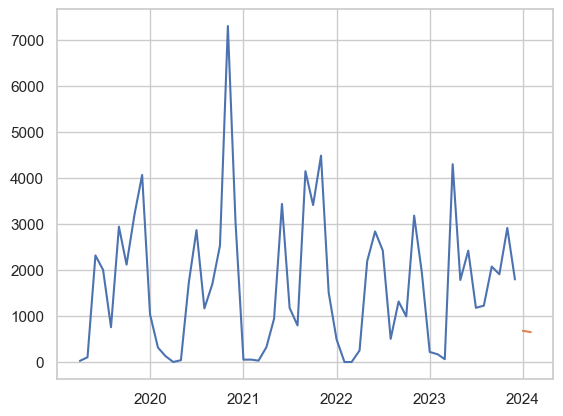


Material: sku858


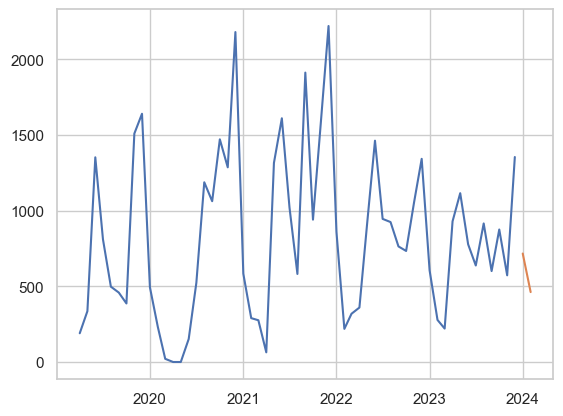


Material: sku837


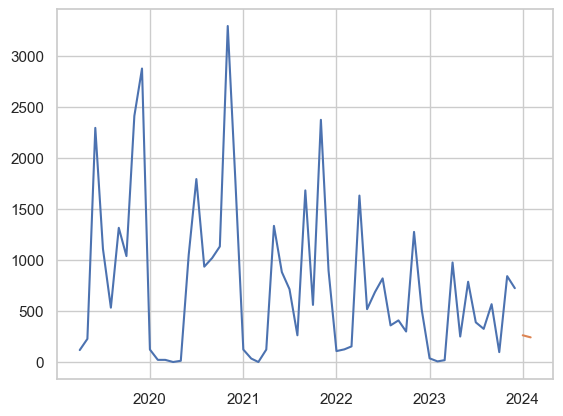


Material: sku859


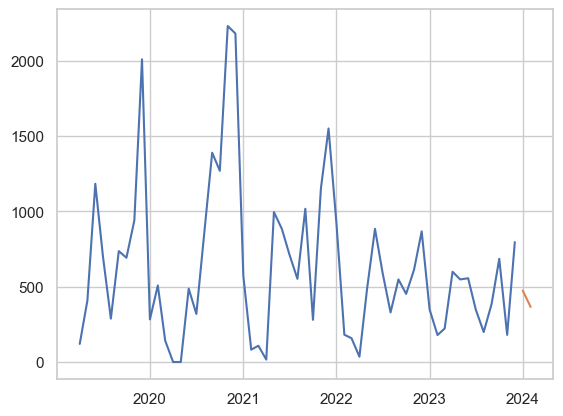


Material: sku863


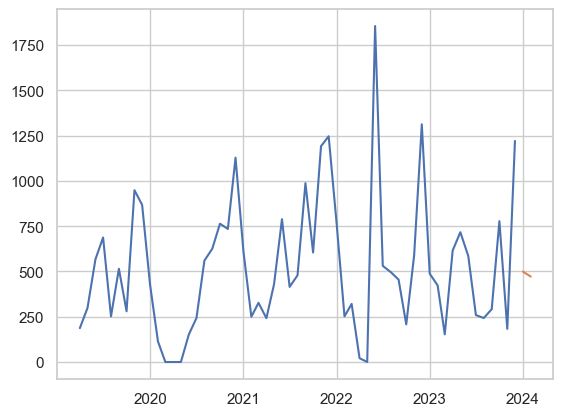


Material: sku862


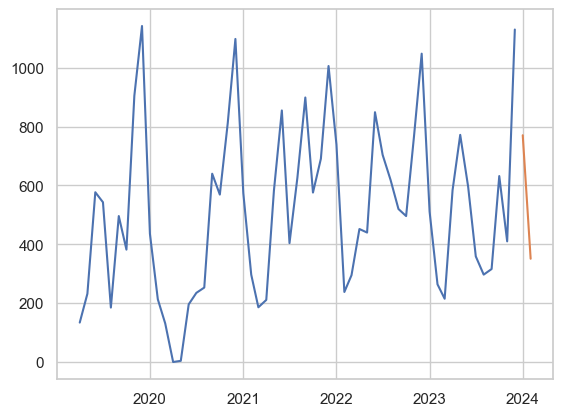


Material: sku903


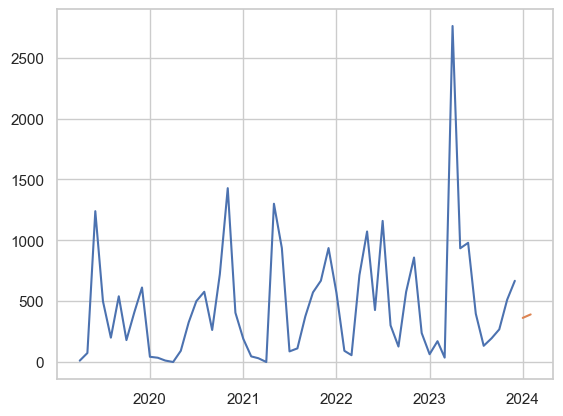


Material: sku1127


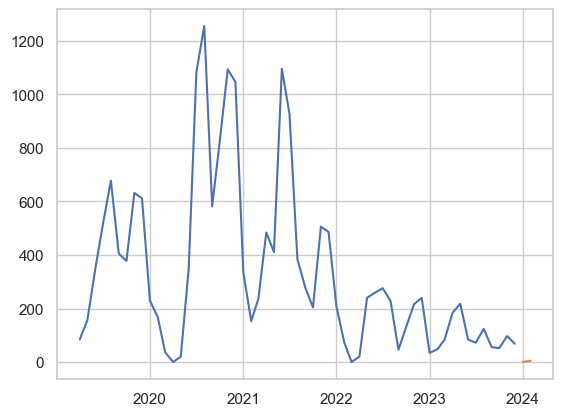


Material: sku169


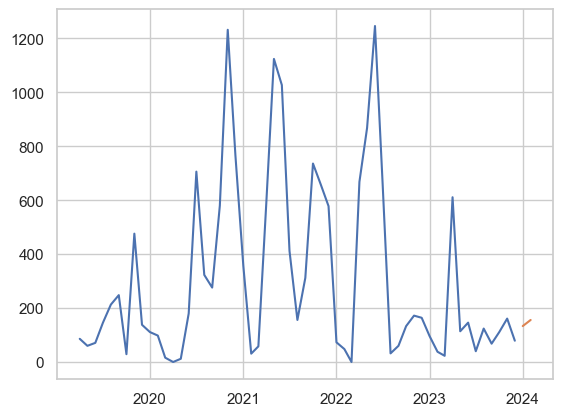


Material: sku230


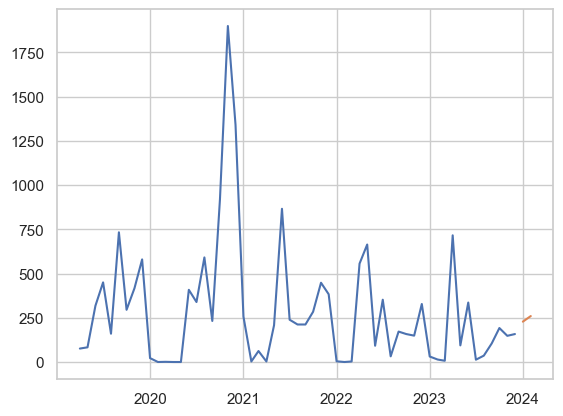


Material: sku947


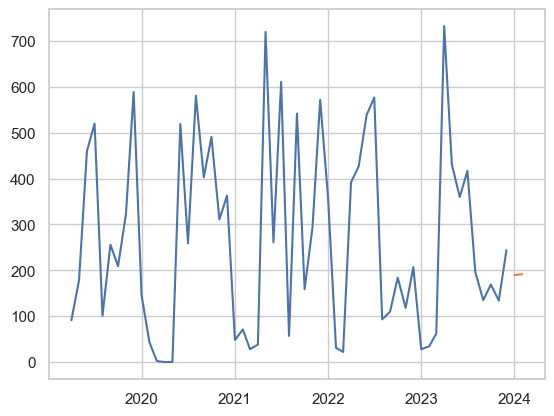


Material: sku1080


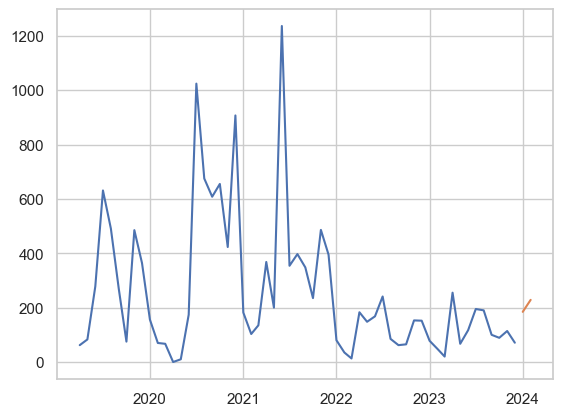


Material: sku1129


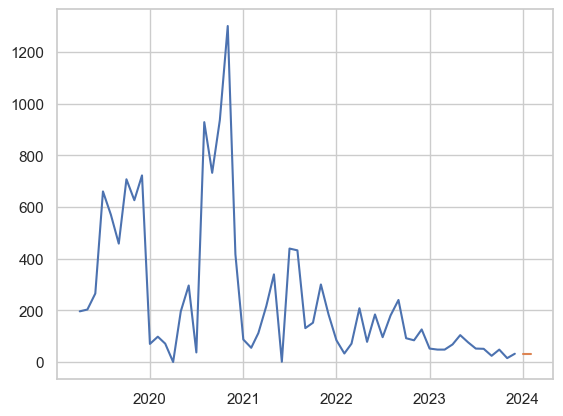


Material: sku1226


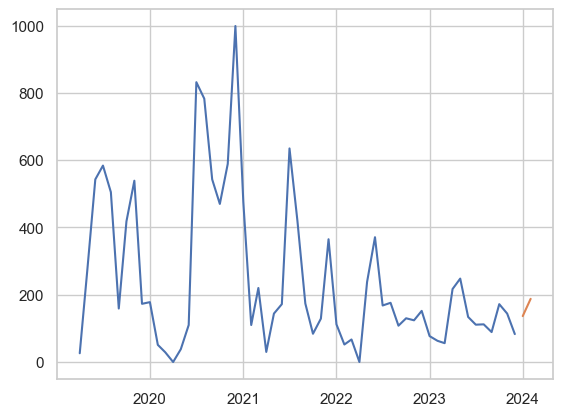


Material: sku861


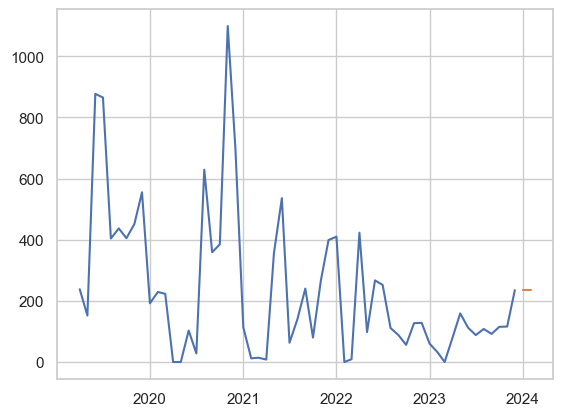


Material: sku120


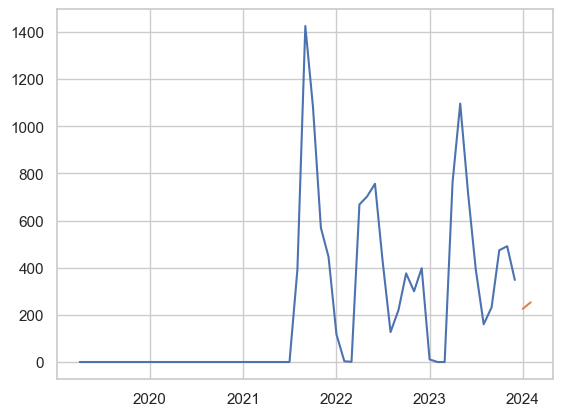


Material: sku1278


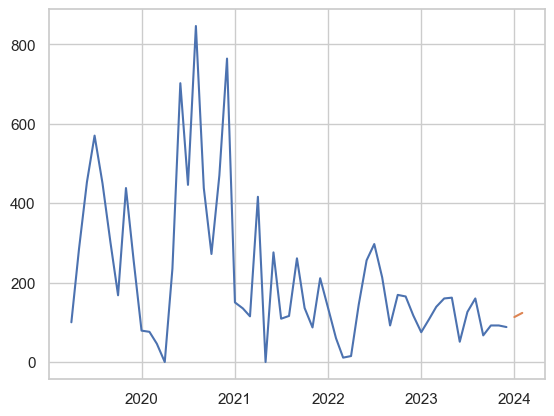


Material: sku1081


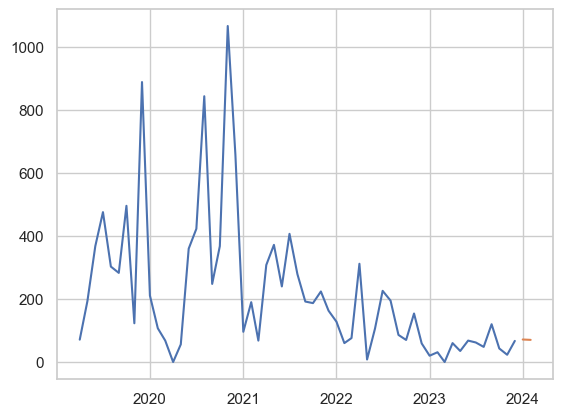


Material: sku270


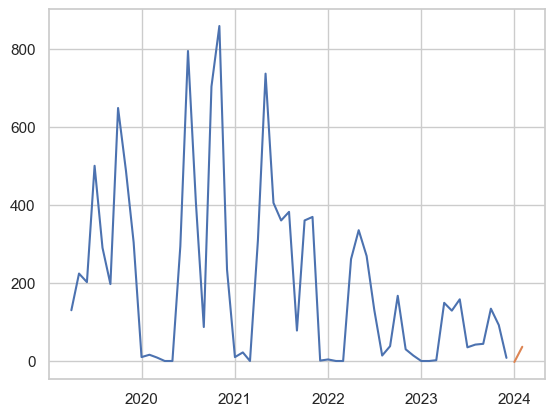


Material: sku492


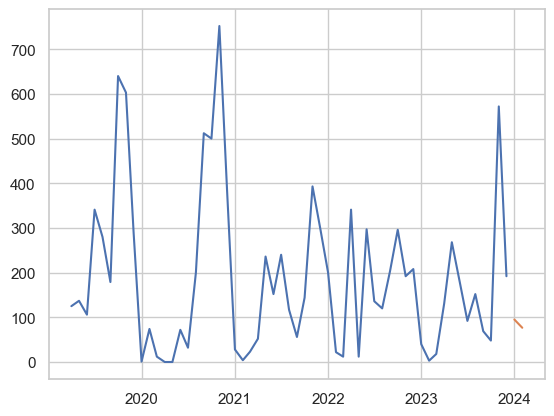


Material: sku1280


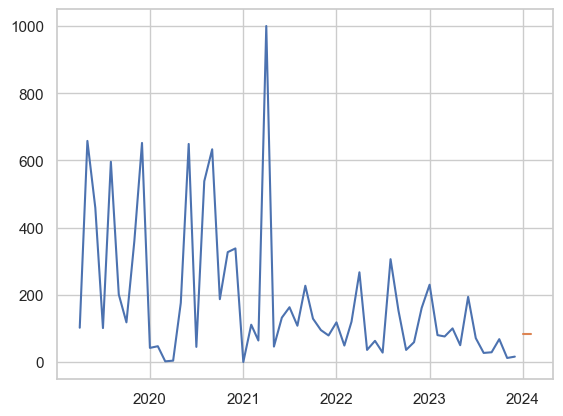


Material: sku255


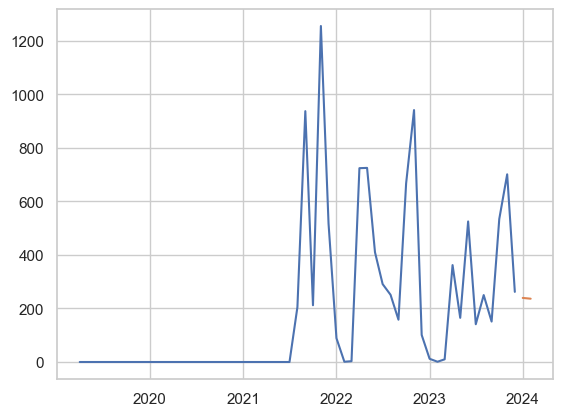


Material: sku709


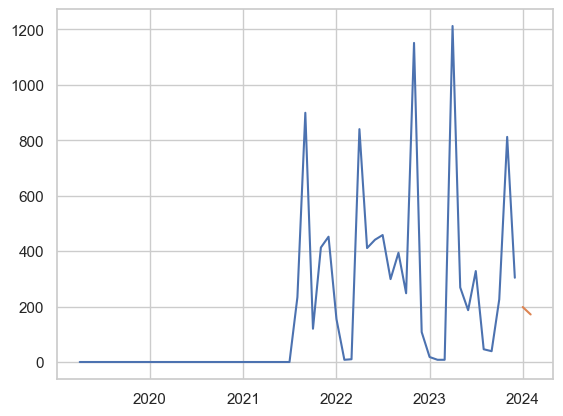


Material: sku1174


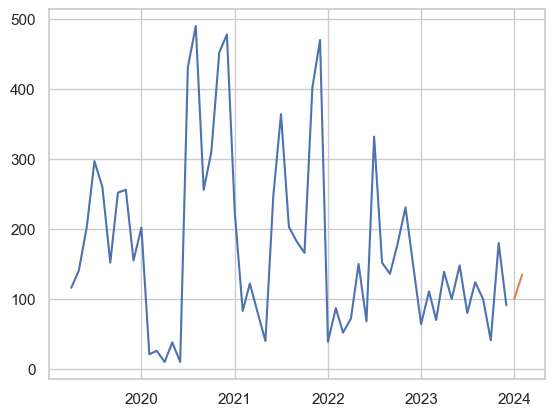


Material: sku239


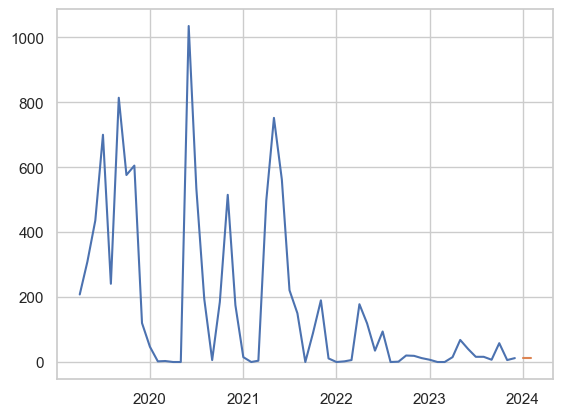


Material: sku209


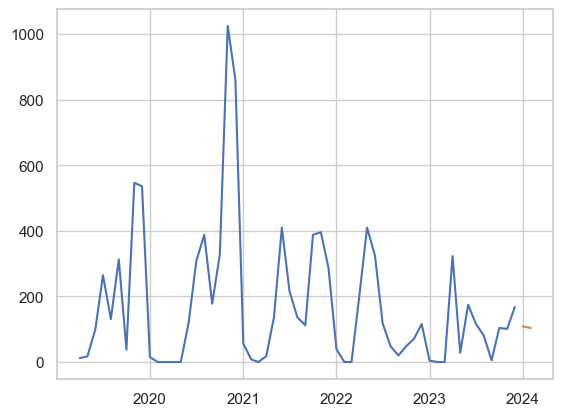


Material: sku498


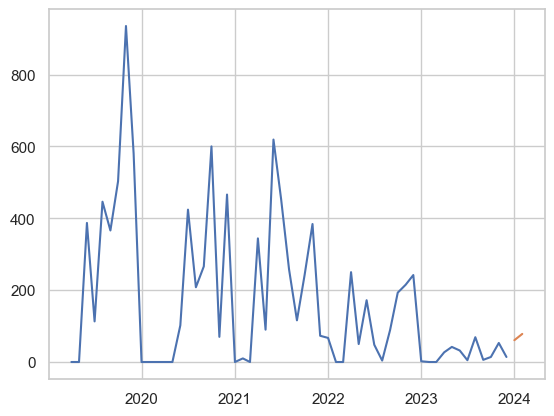


Material: sku949


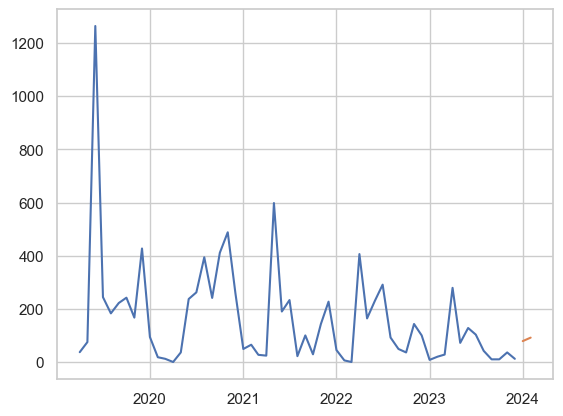


Material: sku138


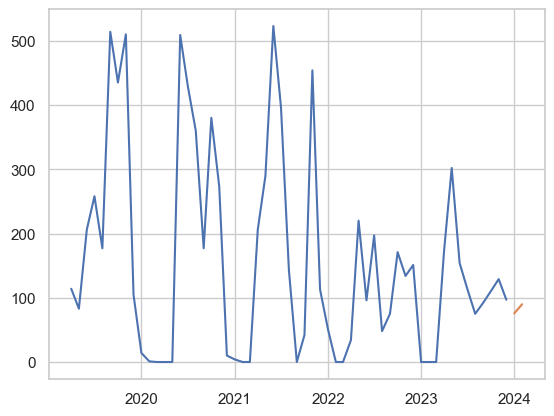


Material: sku1009


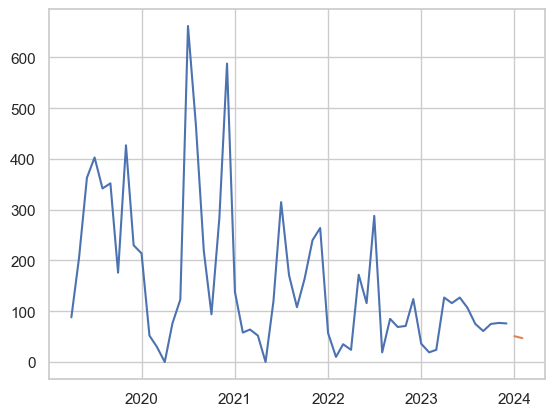


Material: sku1011


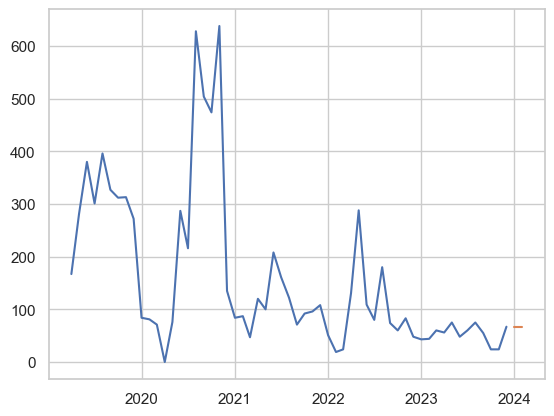


Material: sku905


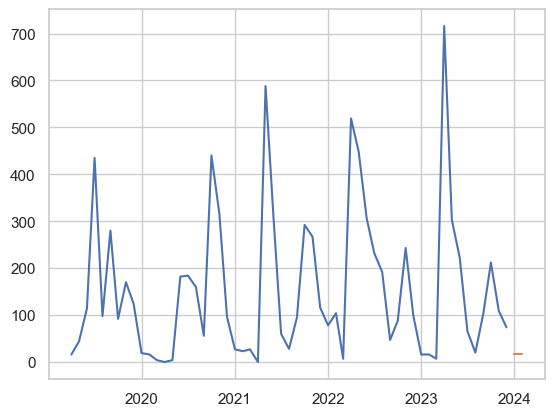


Material: sku231


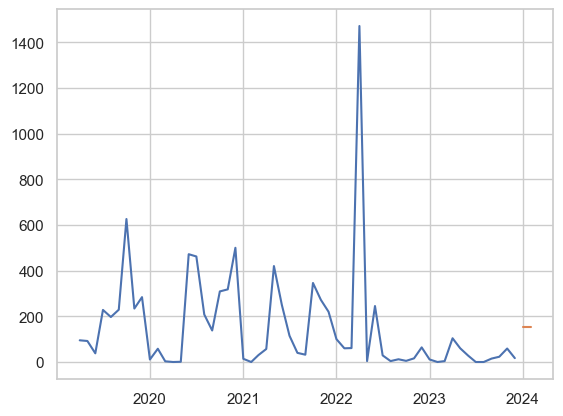


Material: sku716


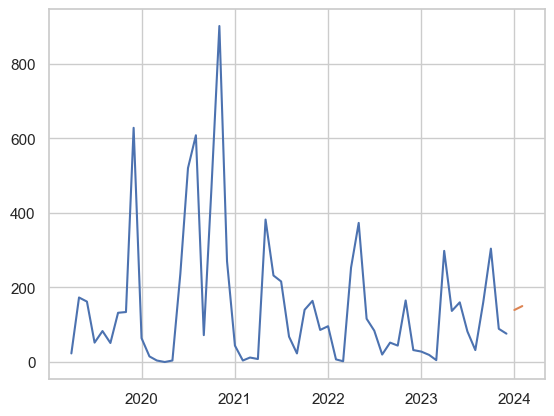


Material: sku499


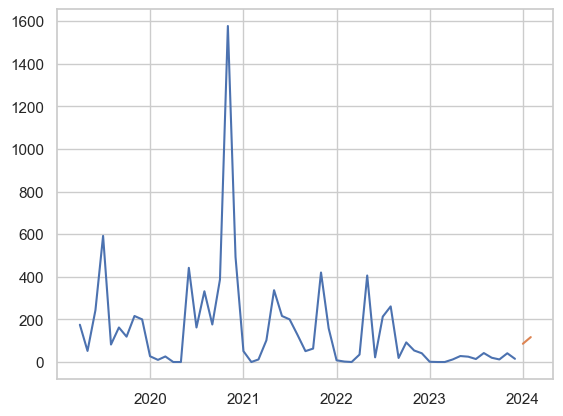


Material: sku271


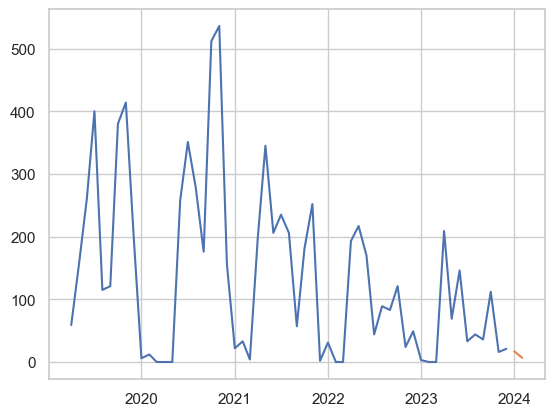


Material: sku122


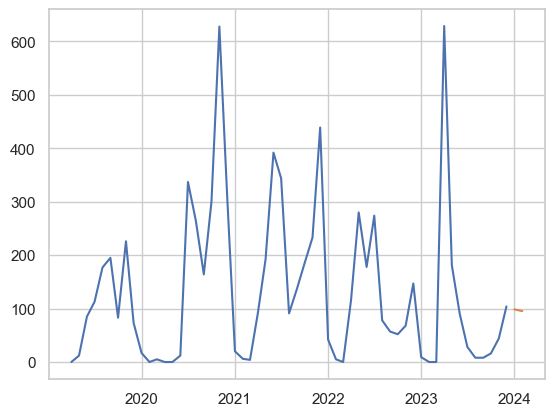


Material: sku486


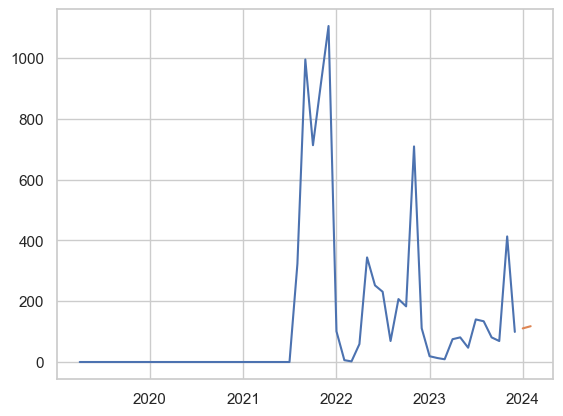


Material: sku327


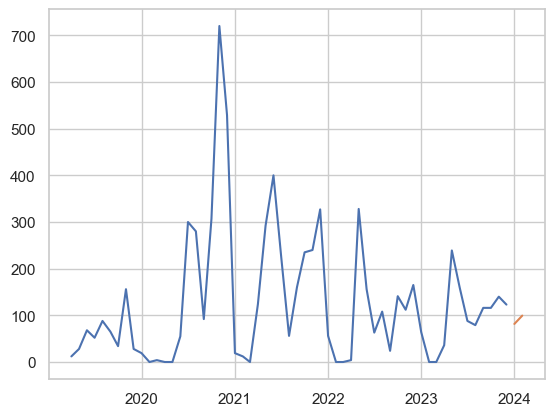


Material: sku366


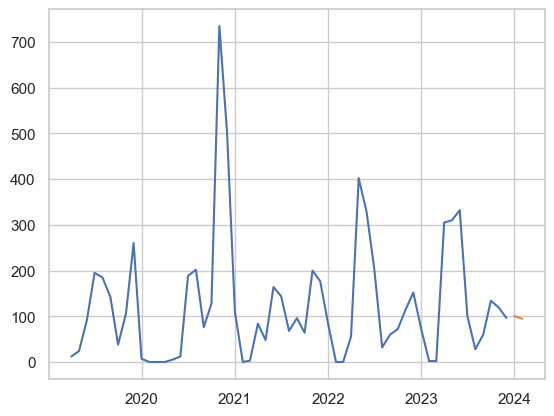


Material: sku1123


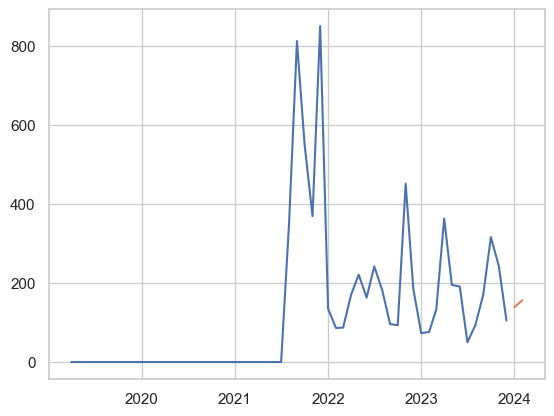


Material: sku167


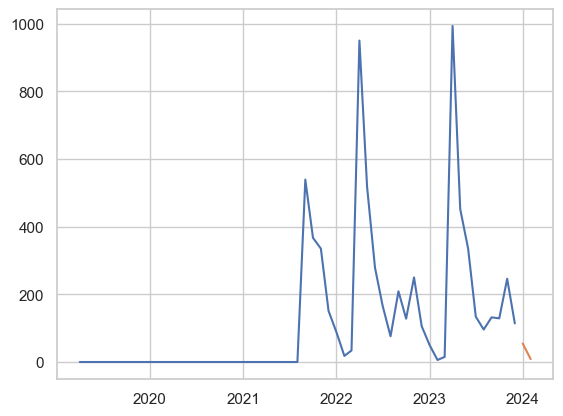


Material: sku824


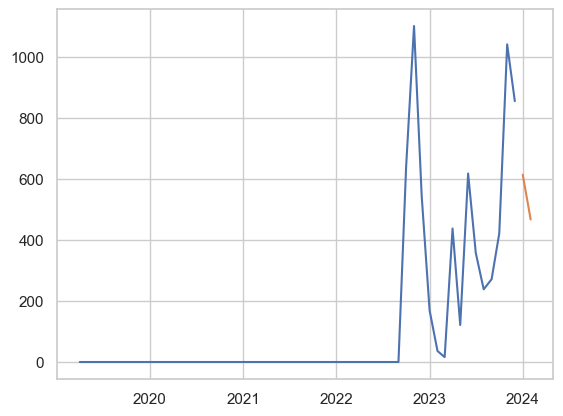


Material: sku1119


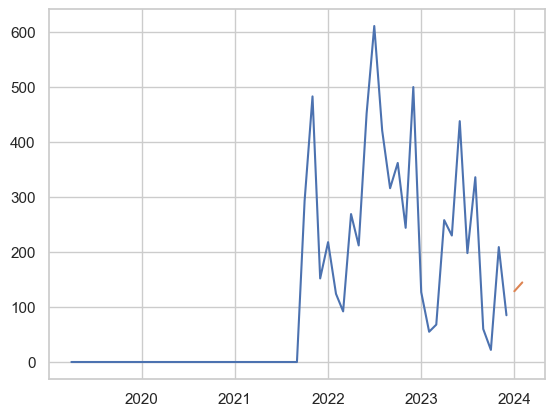


Material: sku1176


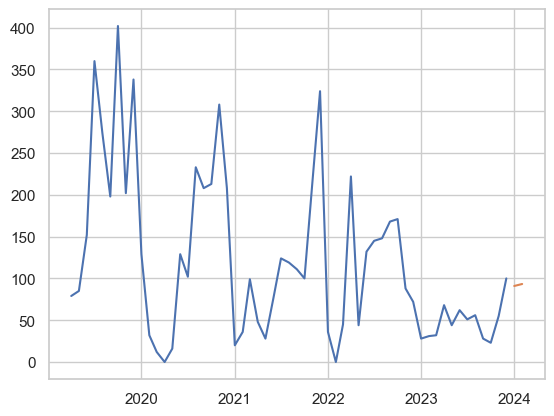


Material: sku1227


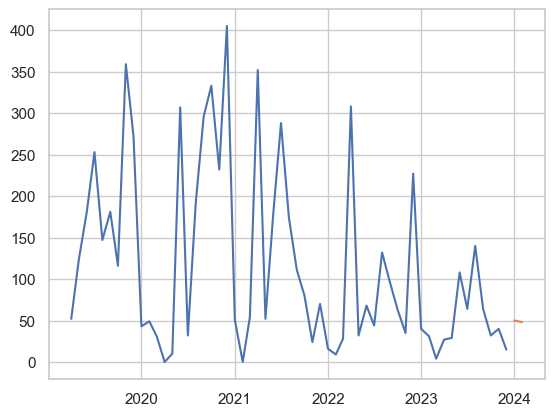


Material: sku184


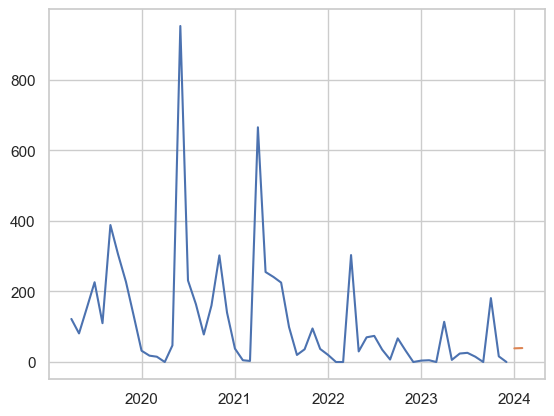


Material: sku652


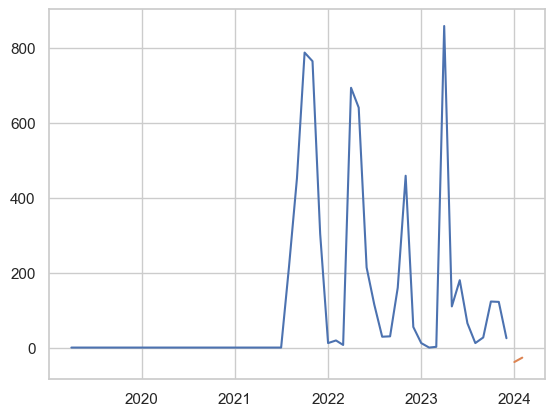


Material: sku734


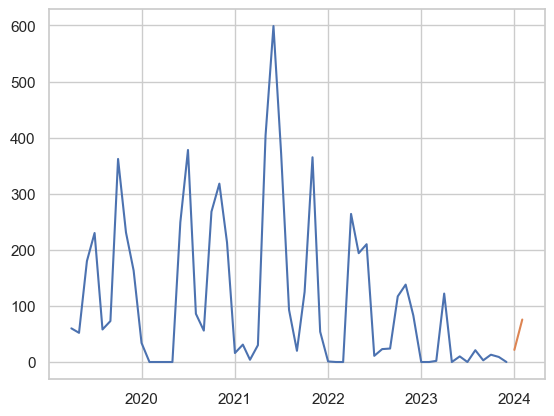

MaterialNumber  Predicted_AUTOARIMA
0          sku835           649.150485
1          sku858           462.219540
2          sku837           241.690955
3          sku859           365.401259
4          sku863           472.022523
5          sku862           350.961227
6          sku903           390.824322
7         sku1127             4.716353
8          sku169           155.881694
9          sku230           259.657807
10         sku947           191.523112
11        sku1080           228.586710
12        sku1129            32.000000
13        sku1226           187.869231
14         sku861           235.000000
15         sku120           253.135088
16        sku1278           123.609341
17        sku1081            70.283277
18         sku270            36.404563
19         sku492            76.666313
20        sku1280            84.414913
21         sku255           236.456785
22         sku709           171.455309
23        sku1174           134.805565
24         sku239            12.000000
25         sku209           103.779260
26         sku498            78.165467
27         sku949            91.719712
28         sku138            89.893248
29        sku1009            47.085128
30        sku1011            67.000000
31         sku905            16.000000
32         sku231           152.473684
33         sku716           149.975038
34         sku499           116.879426
35         sku271             6.801687
36         sku122            95.326608
37         sku486           117.700464
38         sku327            99.428701
39         sku366            94.566837
40        sku1123           156.072797
41         sku167             8.574229
42         sku824           466.616573
43        sku1119           144.678394
44        sku1176            93.328808
45        sku1227            48.067236
46         sku184            39.501027
47         sku652           -26.922323
48         sku734            75.712491

In [136]:
def forecast_sales_autoarima(df, material):
    df_material = prepare_data(df, material)
    print(f"Material: {material}")
    train = df_material
    
    model = auto_arima(train, seasonal=True, stepwise=True, trace=False, error_action='ignore', suppress_warnings=True, m=12)
    model.fit(train)
    forecast = model.predict(n_periods=2)
    predicted = forecast.values
    forecast = pd.DataFrame(forecast,columns=['Prediction_AutoARIMA'])
    plt.plot(train, label='Train')
    plt.plot(forecast, label='Prediction')
    plt.show()
    print()
    
    return predicted[1]

results_autoarima = []

for material in materials:
    predicted = forecast_sales_autoarima(data, material)
    results_autoarima.append((material, predicted))

results_autoarima_df = pd.DataFrame(results_autoarima, columns=['MaterialNumber',  'Predicted_AUTOARIMA'])

results_autoarima_df

In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [154]:
def forecast_sales_sarima_tuned_parallel(df, material):
    df_material = prepare_data(df, material)
    train = df_material
    model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 1, 0, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=2)
    return forecast.values[1]
    

results_sarima_tuned_parallel = []

for material in materials:
    result = forecast_sales_sarima_tuned_parallel(data, material)
    results_sarima_tuned_parallel.append((material, result))

# Convert results to DataFrame for better visualization
results_sarima_tuned_parallel_df = pd.DataFrame(results_sarima_tuned_parallel, columns=['MaterialNumber','Predicted_Tuned_SARIMA'])
results_sarima_tuned_parallel_df


MaterialNumber  Predicted_Tuned_SARIMA
0          sku835              158.128391
1          sku858              264.634071
2          sku837               -0.487037
3          sku859              163.904846
4          sku863              420.607344
5          sku862              225.446771
6          sku903              165.540292
7         sku1127              -21.682686
8          sku169               12.005849
9          sku230              -13.362599
10         sku947               39.944132
11        sku1080               35.329790
12        sku1129               22.845003
13        sku1226               47.012575
14         sku861               24.991229
15         sku120              -59.581415
16        sku1278               86.157213
17        sku1081                5.088135
18         sku270                1.647822
19         sku492                4.301603
20        sku1280              106.309764
21         sku255               -4.306206
22         sku709              -37.717060
23        sku1174               91.053511
24         sku239                0.157079
25         sku209                3.399552
26         sku498              -32.727091
27         sku949                0.291874
28         sku138               -4.224277
29        sku1009               18.214868
30        sku1011               46.730964
31         sku905               22.075194
32         sku231               -1.060702
33         sku716               15.244837
34         sku499               -4.918382
35         sku271               -6.044924
36         sku122               -2.383898
37         sku486                1.039341
38         sku327               -2.619882
39         sku366               -2.505153
40        sku1123               39.003453
41         sku167                8.566764
42         sku824              152.434087
43        sku1119             -144.491145
44        sku1176                6.472996
45        sku1227               11.538330
46         sku184               15.968778
47         sku652                5.267426
48         sku734               -5.487239

In [157]:
comparison_df = results_df.merge(results_ets_df, on='MaterialNumber', suffixes=('_ARIMA','_ETS'))
comparison_df = comparison_df.merge(results_lstm_df, on='MaterialNumber', suffixes=('','_LSTM'))
comparison_df = comparison_df.merge(results_autoarima_df, on='MaterialNumber', suffixes=('','_AUTO_ARIMA'))
comparison_df = comparison_df.merge(results_sarima_tuned_parallel_df, on='MaterialNumber', suffixes=('','_Tuned_SARIMA'))
comparison_df = comparison_df.merge(Croston_models_df, on='MaterialNumber', suffixes=('',''))
comparison_df = comparison_df.merge(XGB_models_df, on='MaterialNumber', suffixes=('',''))

comparison_df

MaterialNumber  Predicted_ARIMA  Predicted_ETS  Predicted_Jan_2024  \
0          sku835           1792.0    -300.271471         1773.078247   
1          sku858           1355.0    -280.403915         1072.756470   
2          sku837            724.0    -653.040667          770.888916   
3          sku859            796.0    -750.068162          729.501160   
4          sku863           1221.0     236.499522          681.484009   
5          sku862           1130.0     147.454205          782.668823   
6          sku903            667.0     254.009581          504.675110   
7         sku1127             68.0    -500.717453          143.896408   
8          sku169             79.0    -406.913849          179.709274   
9          sku230            158.0    -548.237434          232.180069   
10         sku947            244.0     -25.905404          268.826569   
11        sku1080             71.0    -268.726541          178.745346   
12        sku1129             32.0    -407.778208          121.529312   
13        sku1226             83.0    -241.475873          148.929810   
14         sku861            235.0    -157.389900          238.346237   
15         sku120            348.0     171.755724          323.853699   
16        sku1278             88.0    -126.133617          152.341614   
17        sku1081             67.0    -204.921740          155.703735   
18         sku270              8.0    -223.027094          107.332283   
19         sku492            192.0     -46.223605          188.532242   
20        sku1280             16.0    -111.991405          183.569061   
21         sku255            262.0     157.381529          257.396027   
22         sku709            304.0      28.135579          286.914124   
23        sku1174             91.0     -81.357774          136.218185   
24         sku239             12.0    -270.332427           87.014030   
25         sku209            168.0    -302.808974          174.581360   
26         sku498             14.0    -300.462896          109.772614   
27         sku949             12.0    -112.263785          145.337051   
28         sku138             97.0     -98.397045          127.708473   
29        sku1009             76.0    -100.626313          117.542709   
30        sku1011             67.0     -86.146608           93.412682   
31         sku905             74.0      75.830852          138.489288   
32         sku231             17.0    -159.490795          125.521111   
33         sku716             76.0     -89.599273          129.126205   
34         sku499             15.0    -288.457482          103.518494   
35         sku271             21.0    -132.785751           75.700447   
36         sku122            104.0    -124.669907          127.112679   
37         sku486             99.0    -157.476247          118.190445   
38         sku327            123.0    -120.549196          124.527580   
39         sku366             96.0    -181.056873          112.472832   
40        sku1123            105.0     -19.673670          125.285370   
41         sku167            114.0      96.815622          119.249069   
42         sku824            854.0     861.248564          686.477295   
43        sku1119             85.0       4.204240          102.059036   
44        sku1176            100.0    -125.011384          112.360321   
45        sku1227             15.0    -107.432039           92.806709   
46         sku184              0.0    -124.715081           88.183456   
47         sku652             25.0    -115.111112           66.829651   
48         sku734              0.0    -157.541122           57.334625   

    Predicted_Feb_2024  Predicted_AUTOARIMA  Predicted_Tuned_SARIMA  \
0          1766.400269           649.150485              158.128391   
1           972.322144           462.219540              264.634071   
2           785.402466           241.690955               -0.487037   
3           697.708252           365.401259              163.904846 

In [158]:
comparison_df.to_csv('forecast_feb_2024.csv', index=False)